In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import the pandas library
import pandas as pd

file_name = "month_data.csv"
# Define the file path
file_path = r"../" +"data" + "/" + file_name

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';', encoding='utf-8')

# Display the first few rows of the DataFrame
#print(df.head())

In [4]:
import numpy as np

specific_date = '2019-03-27'  # Change this to desired date
start_time = '7:00:00' #select peak hours of the day
end_time = '19:00:00'

#filter the dataset to specific date and get a copy
filtered_for_date=df[(df['Datum_PAU']== specific_date)].copy()

#convert planned arrival time and planned departure time to date time format
filtered_for_date['PlanAnkTid'] = pd.to_datetime(filtered_for_date['PlanAnkTid'],errors='coerce')
filtered_for_date['PlanAvgTid'] = pd.to_datetime(filtered_for_date['PlanAvgTid'],errors='coerce')

#filter the dataset for the peak time
filtered_for_date = filtered_for_date[((filtered_for_date['PlanAnkTid'].dt.time >= pd.to_datetime(start_time).time()) &
                                      (filtered_for_date['PlanAnkTid'].dt.time <= pd.to_datetime(end_time).time())) | 
                                      ((filtered_for_date['PlanAvgTid'].dt.time >= pd.to_datetime(start_time).time()) &
                                      (filtered_for_date['PlanAvgTid'].dt.time <= pd.to_datetime(end_time).time()))]

#filter for the platform
filtered_for_platform= filtered_for_date[(filtered_for_date['Ankomstplats']=='Uppsala c') | ( filtered_for_date['Avgångsplats']=='Uppsala c' )]

#List of unique mission station codes to filter by
unique_missions_for_given_station = ['U', 'Gä', 'Cst','Fln']

#Filter the DataFrame based on starting or ending stations matching the unique mission codes
filtered_for_unique_mission_for_given_station = filtered_for_platform[
    (filtered_for_platform['Förstaplatssignatur_för_Uppdrag'].isin(unique_missions_for_given_station)) &
    (filtered_for_platform['Sistaplatssignatur_för_Uppdrag'].isin(unique_missions_for_given_station))
]

# Extract the unique Tåguppdrag values from the filtered dataset
unique_missions = filtered_for_unique_mission_for_given_station['Tåguppdrag'].unique()

# Display the unique Tåguppdrag values
print("Unique Tåguppdrag for specified stations:", unique_missions)



Unique Tåguppdrag for specified stations: [ 855. 8423. 8428.  845. 8416.   17.  843. 8410.   20. 8408.  823.  836.
  825.  846. 8420.   13.  815.  882.  841.  895. 8461.  271.  894.  896.
  838.  893.  857.   19.  848.  853.  816.  808. 8457. 8450.  828. 8455.
  891.  812.  859.  881. 8431.  829.   14.   22.  806.  827. 8463.  818.
 8424. 8436. 8446. 8451.  887. 8435.  822.   64.  833.  884.  889.  892.
 8417.  831.  890.  817. 8432.  883. 8459.  280. 8419.  839.  837.  826.
  824. 8440. 8412.  819. 8442.  849. 8447. 8448.  820.  814.  821.   51.
 8421.  840.  835. 8201.  844.  842. 8444. 8425.  834.  851.  813. 8443.
 8452.  852.  810.  830.  832.  850. 8427. 8439.]


In [5]:

import pandas as pd

#excluding train missions as they do not show Första or Sista
excluded_missions= [13,51,882,806,8417,8419]

# List of specific mission types interested in
mission_types = unique_missions[~np.isin(unique_missions, excluded_missions)]

# Initialize a dictionary to hold routes for each mission
all_routes = {}
all_filtered_rows = []  # List to store rows used to generate the routes

# Loop through each mission type
for mission_type in mission_types:
    # Initialize a list to hold the routes for the current mission
    routes = []

    # Step 4: Iterate through the DataFrame to build routes
    for index, row in filtered_for_date.iterrows():
        if row['UppehållstypAvgång'] == 'Första' and row['Tåguppdrag'] == mission_type:
            # Start the route with the departure station
            current_route = [row['Avgångsplats']]
            all_filtered_rows.append(row)  # Save the current row to the list
            next_row = row

            # Add the arrival station of the "Första" row to the route as the next stop
            current_route.append(next_row['Ankomstplats'])
             
            # Continue to add stations until reaching 'Sista'
            while next_row['UppehållstypAnkomst'] != 'Sista':
                # Find the next station in the DataFrame that matches the current departure station
                next_station = filtered_for_date[(filtered_for_date['Avgångsplats'] == next_row['Ankomstplats']) &
                                  (filtered_for_date['Tåguppdrag'] == mission_type)]
                

                if not next_station.empty:
                    next_stop = next_station.iloc[0]['Ankomstplats']
                    current_route.append(next_stop)
                    all_filtered_rows.append(next_station.iloc[0])  # Save the row to the list
                    next_row = next_station.iloc[0]  # Move to the next row

                else:
                    break  # Exit if no further stations are found

            # If the last station is 'Sista', append it to the route
            if next_row['UppehållstypAnkomst'] == 'Sista' and next_row['Ankomstplats'] != current_route[-1]:
                current_route.append(next_row['Ankomstplats'])

            # Add the complete route to the routes list
            routes.append(" -> ".join(current_route))

    # Store the routes for the current mission in the dictionary
    all_routes[mission_type] = routes

# Save the filtered rows used to generate the routes into a new DataFrame
filtered_rows_df = pd.DataFrame(all_filtered_rows)



In [6]:
import preprocessing

In [7]:
preprocessing.create_ids(filtered_rows_df)
preprocessing.missing_utfAvgTid(filtered_rows_df)


------Missing values filled------
total missing values in UtfAvgTid 14
total missing values in UtfAnkTid 0
after update total nan avg values are  0
after update total nan ank values are  0






In [ ]:
#Descriptive statistic of test network
print('Number of unique train missions used for test network: ',len(unique_missions))


#total records included in the test network
print('Number of total records in the test network:',len(filtered_rows_df))

#number of unique depature stations
print('Number of unique depature stations in the test network:',len(filtered_rows_df['Avgångsplats'].unique()))

#number of unique arrival stations
print('Number of unique arrival stations in the test network:',len(filtered_rows_df['Ankomstplats'].unique()))

#number of unique routes
print('Number of unique routes available in the test network:',len(filtered_rows_df[['Ankomstplats','Avgångsplats']].drop_duplicates()))

#number of depature delays
print('Number of depature delays:',len(filtered_rows_df[filtered_rows_df['AvgFörsening'] > 0].dropna(subset=['AvgFörsening'])))

#maximum depature delay across all routes
print('Maximum depature delay from a station across all routes(minutes):', max(filtered_rows_df['AvgFörsening'] ))

#early depature across all routes
print('Maximum early depature from a station across all routes(minutes):',min(filtered_rows_df['AvgFörsening']))

#number of arrival delays
print('Number of arrival delays:',len(filtered_rows_df[filtered_rows_df['AnkFörsening']>0].dropna(subset=['AnkFörsening'])))

#maximum arrival delay across all routes
print('Maximum arrival delay to a station across all routes(minutes):', max(filtered_rows_df['AnkFörsening'] ))

#early arrival across all routes
print('Maximum early arrival to a station across all routes(minutes):',min(filtered_rows_df['AnkFörsening']))

#Number of edges delay in travel time
print('Number of edges delay in travel time: ', len(filtered_rows_df[filtered_rows_df['FörseningUppehållAvgång']>0]))

#maximum travel time delay across edges
print('Maximum travel time delay within edges:',max(filtered_rows_df['FörseningUppehållAvgång'].dropna()))

#Number of trains with no delays
no_delay_count = len(filtered_rows_df[
            (filtered_rows_df['AnkFörsening']<=0) & 
             (filtered_rows_df['AvgFörsening']<=0) & 
             (filtered_rows_df['FörseningUppehållAvgång']<=0)
             ]
             )
print('Number of trains with no delays:',no_delay_count)



Number of unique train missions used for test network:  104
Number of total records in the test network: 2087
Number of unique depature stations in the test network: 76
Number of unique arrival stations in the test network: 76
Number of unique routes available in the test network: 141
Number of depature delays: 937
Maximum depature delay from a station across all routes(minutes): 33.0
Maximum early depature from a station across all routes(minutes): -7.0
Number of arrival delays: 843
Maximum arrival delay to a station across all routes(minutes): 33.0
Maximum early arrival to a station across all routes(minutes): -4.0
Number of edges delay in travel time:  382
Maximum travel time delay within edges: 10.0
Number of trains with no delays: 831


In [9]:


# Save the DataFrame to a CSV file
output_rows_file_name = 'test_network_week_45_bigger.csv'
filtered_rows_df.to_csv('../data/' + output_rows_file_name, index=False, encoding='utf-8-sig')


# Display the routes for each mission
for mission, routes in all_routes.items():
    print(f"\nRoutes for {mission}:")
    for route in routes:
        print("Route:", route)




Routes for 855.0:
Route: Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Märsta -> Brista -> Rosersberg -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> Sollentuna -> Kummelby -> Helenelund -> Ulriksdal -> Solna -> Tomteboda övre -> Karlberg -> Stockholm C

Routes for 8423.0:
Route: Gävle c -> Bomansberget -> Furuvik -> Skutskär -> Älvkarleby -> Marma norra -> Marma -> Mehedeby -> Orrskog -> Tierp -> Skärpan -> Tobo -> Örbyhus -> Järlebo -> Skyttorp -> Salsta -> Vattholma -> Storvreta -> Samnan -> Uppsala c

Routes for 8428.0:
Route: Uppsala c -> Samnan -> Storvreta -> Vattholma -> Salsta -> Skyttorp -> Järlebo -> Örbyhus -> Tobo -> Skärpan -> Tierp -> Orrskog -> Mehedeby -> Marma -> Marma norra -> Älvkarleby -> Skutskär -> Furuvik -> Bomansberget -> Gävle c

Routes for 845.0:
Route: Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Märsta -> Brista -> Rosersberg -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> Sollentuna -> Kummelby -

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import sys 
import os 

sys.path.append(os.path.abspath('../'))

from network.model import Network

file_path = r"../data/test_network_week_45_bigger.csv"
df_network = pd.read_csv(file_path, sep=',', encoding='utf-8')


#initialize the network
network = Network()
network.initate_network(df_network)

# Fetch delay matrix at a specific time
current_delay_matrix = network.fetch_D_matrix(df_network)


    




c:\D\achini\Project-In-Data-Science-\network\model.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Aji = self.A_matrix.iloc[col_index][row_index]


Visualizing delay for time step 0
Network time:  2019-03-27 07:51:00
Delay matrix at time:  2019-03-27 07:51:00
Rosersberg: -117529363.283
Skavstaby: 2164614916.723
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: -710428.511
Uppsala norra: -0.069
Solna: -220713298196.134
Tomteboda övre: 30411490415.653
Samnan: -0.001
Karlberg: -5673301896.39
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: 174.198
Ulriksdal: 1289818397150.094
Mehedeby: -0.0
Vattholma: -0.001
Arlanda Central: -634094.732
Rotebro: 355626050810.321
Salsta: -0.0
Helenelund: -8990118405429.588
Sollentuna: -11881007900692.734
Kummelby: 16997484389901.645
Myrbacken: 78661.119
Stockholm C: 389768083.491
Örbyhus: -0.0
Norrviken: -1431080744666.299
Gävle c: -0.0
Blackvreten: -54250826.532
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: 9292007.95
Knivsta: -4042.199
Marma: -0.0
Häggvik: 3883839546399.588
Säby: -8.096
Storvreta: -0.0
Älvkarleby: -0.0
Arlanda nedre: 3653839.404
Skärpan: -0.0
Orrskog: -0.0
Upplands Väsby: -30941501005

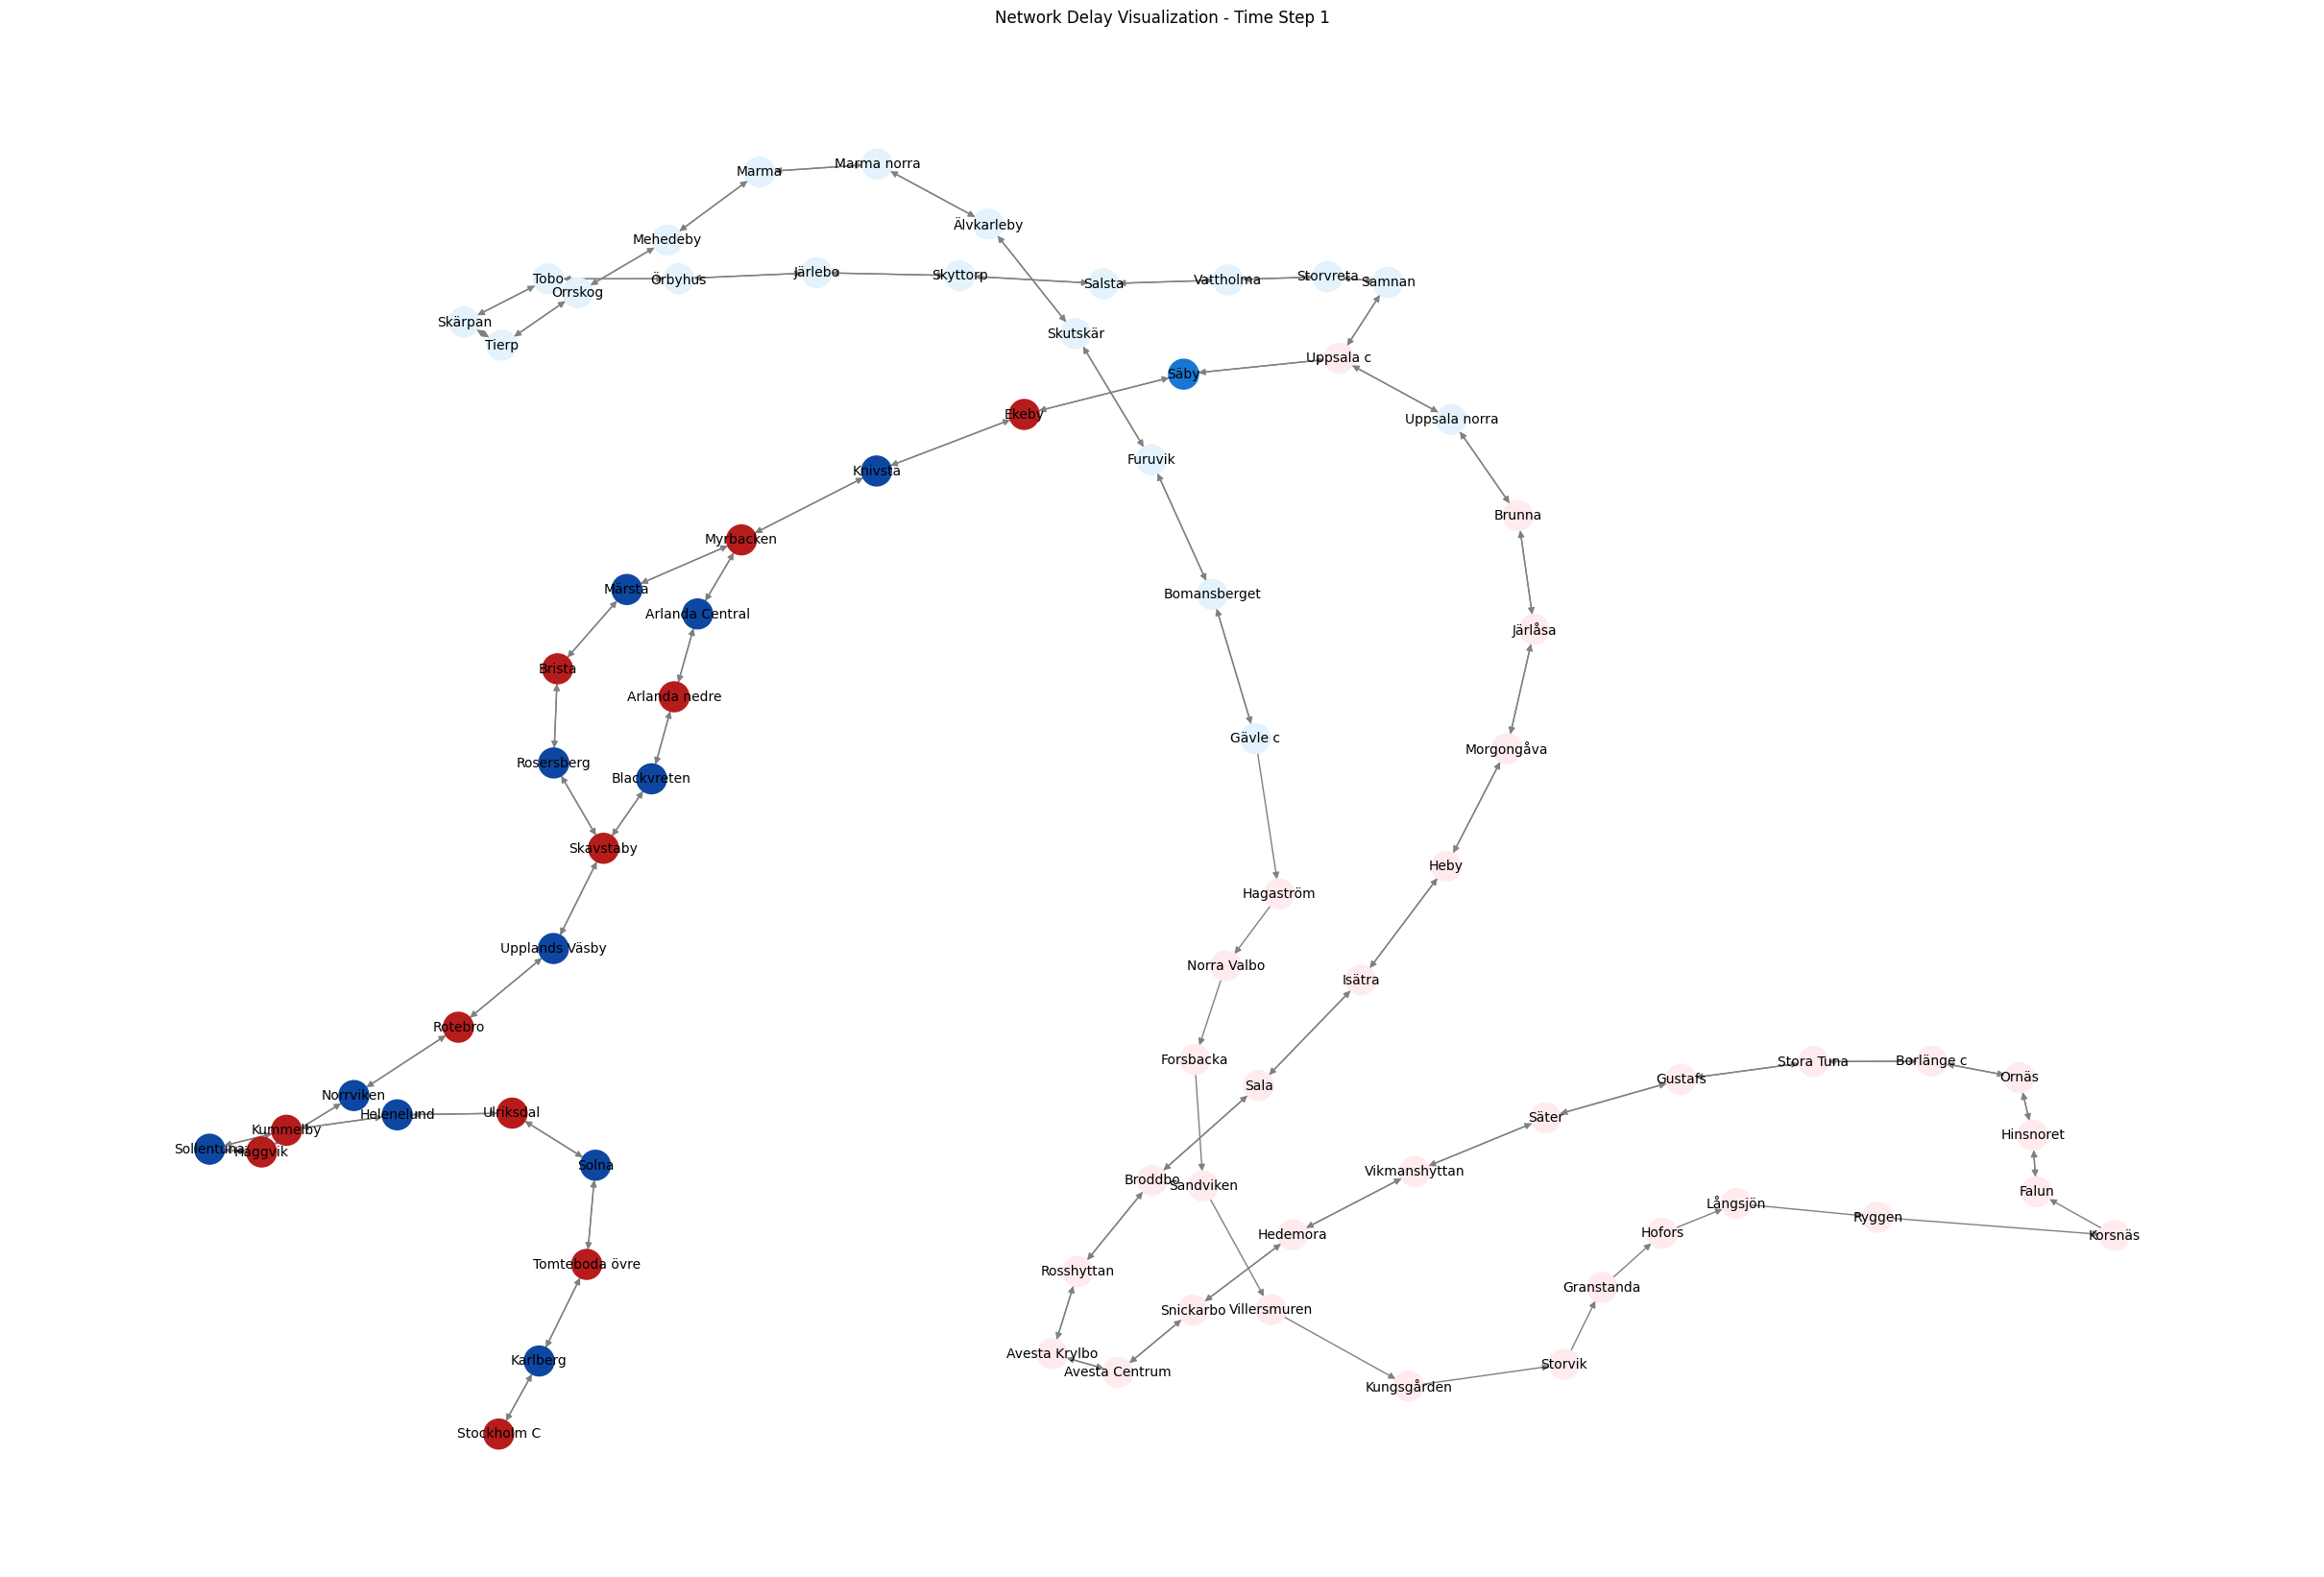

Visualizing delay for time step 1
Network time:  2019-03-27 07:51:00
Delay matrix at time:  2019-03-27 07:51:00
Rosersberg: -117529363.283
Skavstaby: 2164614916.723
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: -710428.511
Uppsala norra: -0.069
Solna: -220713298196.134
Tomteboda övre: 30411490415.653
Samnan: -0.001
Karlberg: -5673301896.39
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: 174.198
Ulriksdal: 1289818397150.094
Mehedeby: -0.0
Vattholma: -0.001
Arlanda Central: -634094.732
Rotebro: 355626050810.321
Salsta: -0.0
Helenelund: -8990118405429.588
Sollentuna: -11881007900692.734
Kummelby: 16997484389901.645
Myrbacken: 78661.119
Stockholm C: 389768083.491
Örbyhus: -0.0
Norrviken: -1431080744666.299
Gävle c: -0.0
Blackvreten: -54250826.532
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: 9292007.95
Knivsta: -4042.199
Marma: -0.0
Häggvik: 3883839546399.588
Säby: -8.096
Storvreta: -0.0
Älvkarleby: -0.0
Arlanda nedre: 3653839.404
Skärpan: -0.0
Orrskog: -0.0
Upplands Väsby: -30941501005

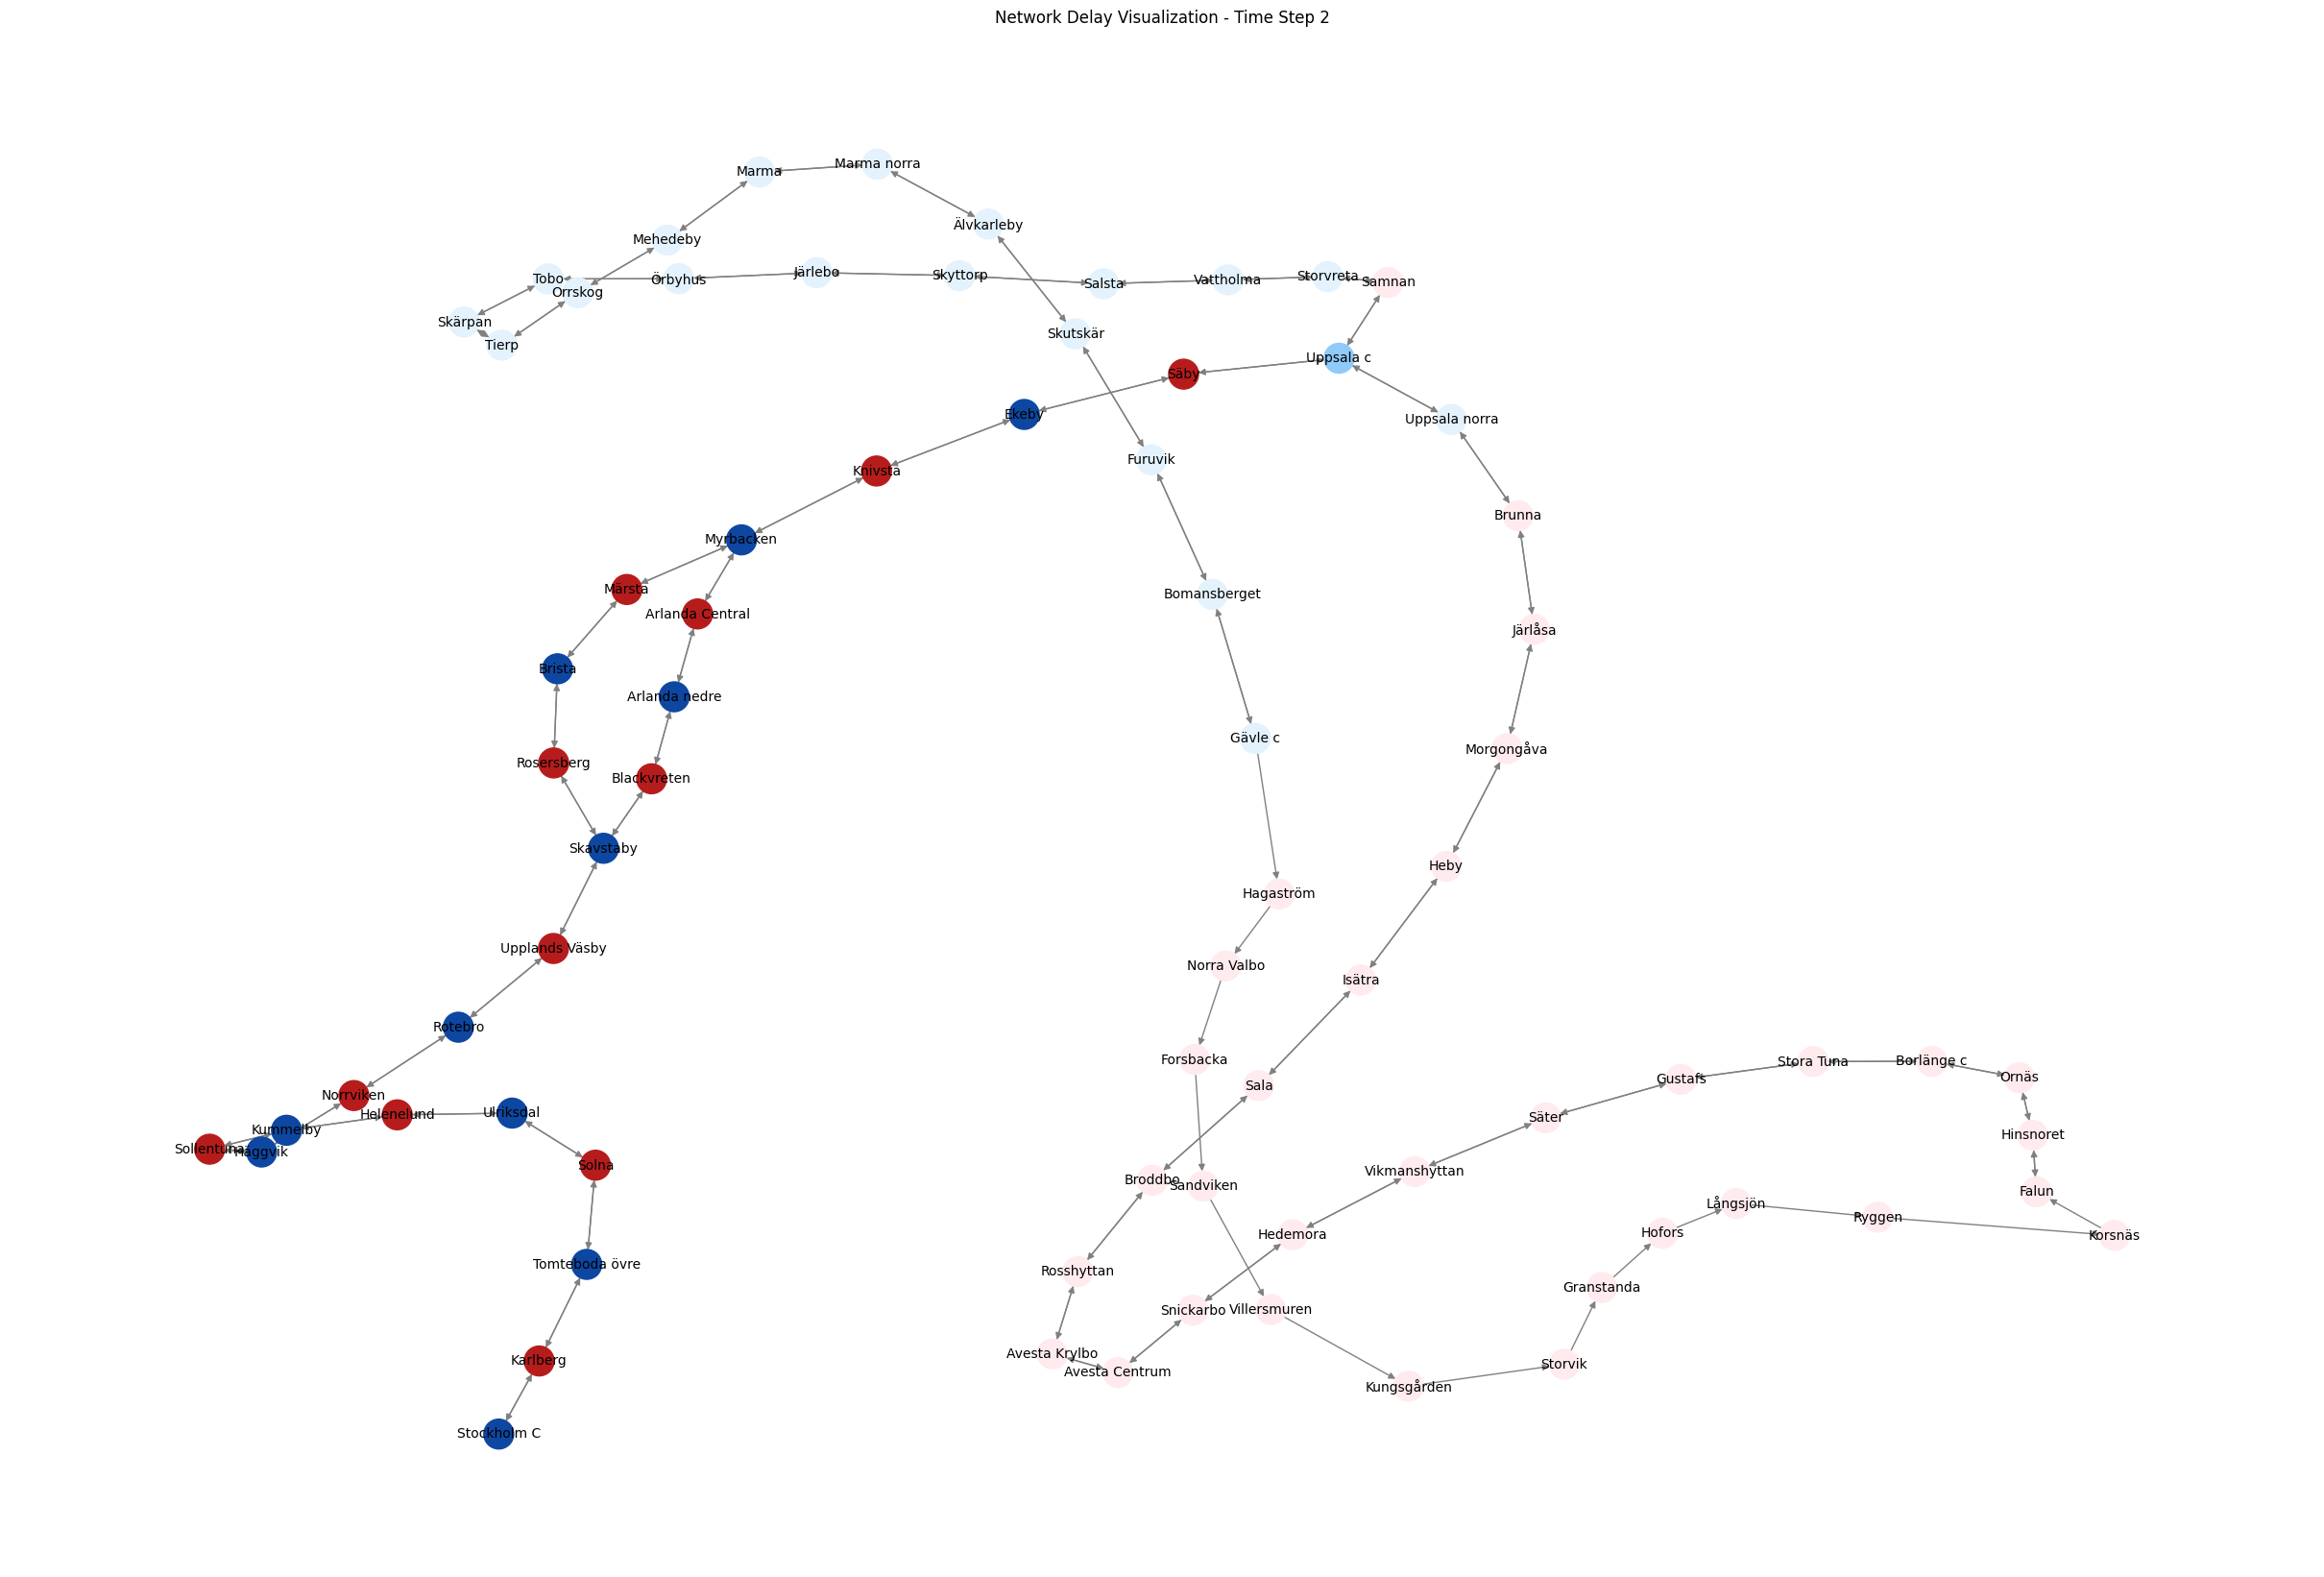

Visualizing delay for time step 2
Network time:  2019-03-27 07:52:00
Delay matrix at time:  2019-03-27 07:52:00
Rosersberg: 379978703.356
Skavstaby: -6998315556.978
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: 2296853.153
Uppsala norra: -0.059
Solna: 713577875802.884
Tomteboda övre: -98321972035.88
Samnan: 0.001
Karlberg: 18342087903.532
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: -563.272
Ulriksdal: -4170051734489.786
Mehedeby: -0.0
Vattholma: -0.001
Arlanda Central: 2050062.064
Rotebro: -1149758005616.177
Salsta: -0.0
Helenelund: 29065532738293.992
Sollentuna: 38411932802923.47
Kummelby: -54953774435124.516
Myrbacken: -254315.695
Stockholm C: -1260141022.173
Örbyhus: -0.0
Norrviken: 4626760441233.875
Gävle c: -0.0
Blackvreten: 175395817.279
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: -30041557.49
Knivsta: 13068.531
Marma: -0.0
Häggvik: -12556660586285.293
Säby: 26.132
Storvreta: -0.0
Älvkarleby: -0.0
Arlanda nedre: -11813057.734
Skärpan: -0.0
Orrskog: -0.0
Upplands Väsby: 1

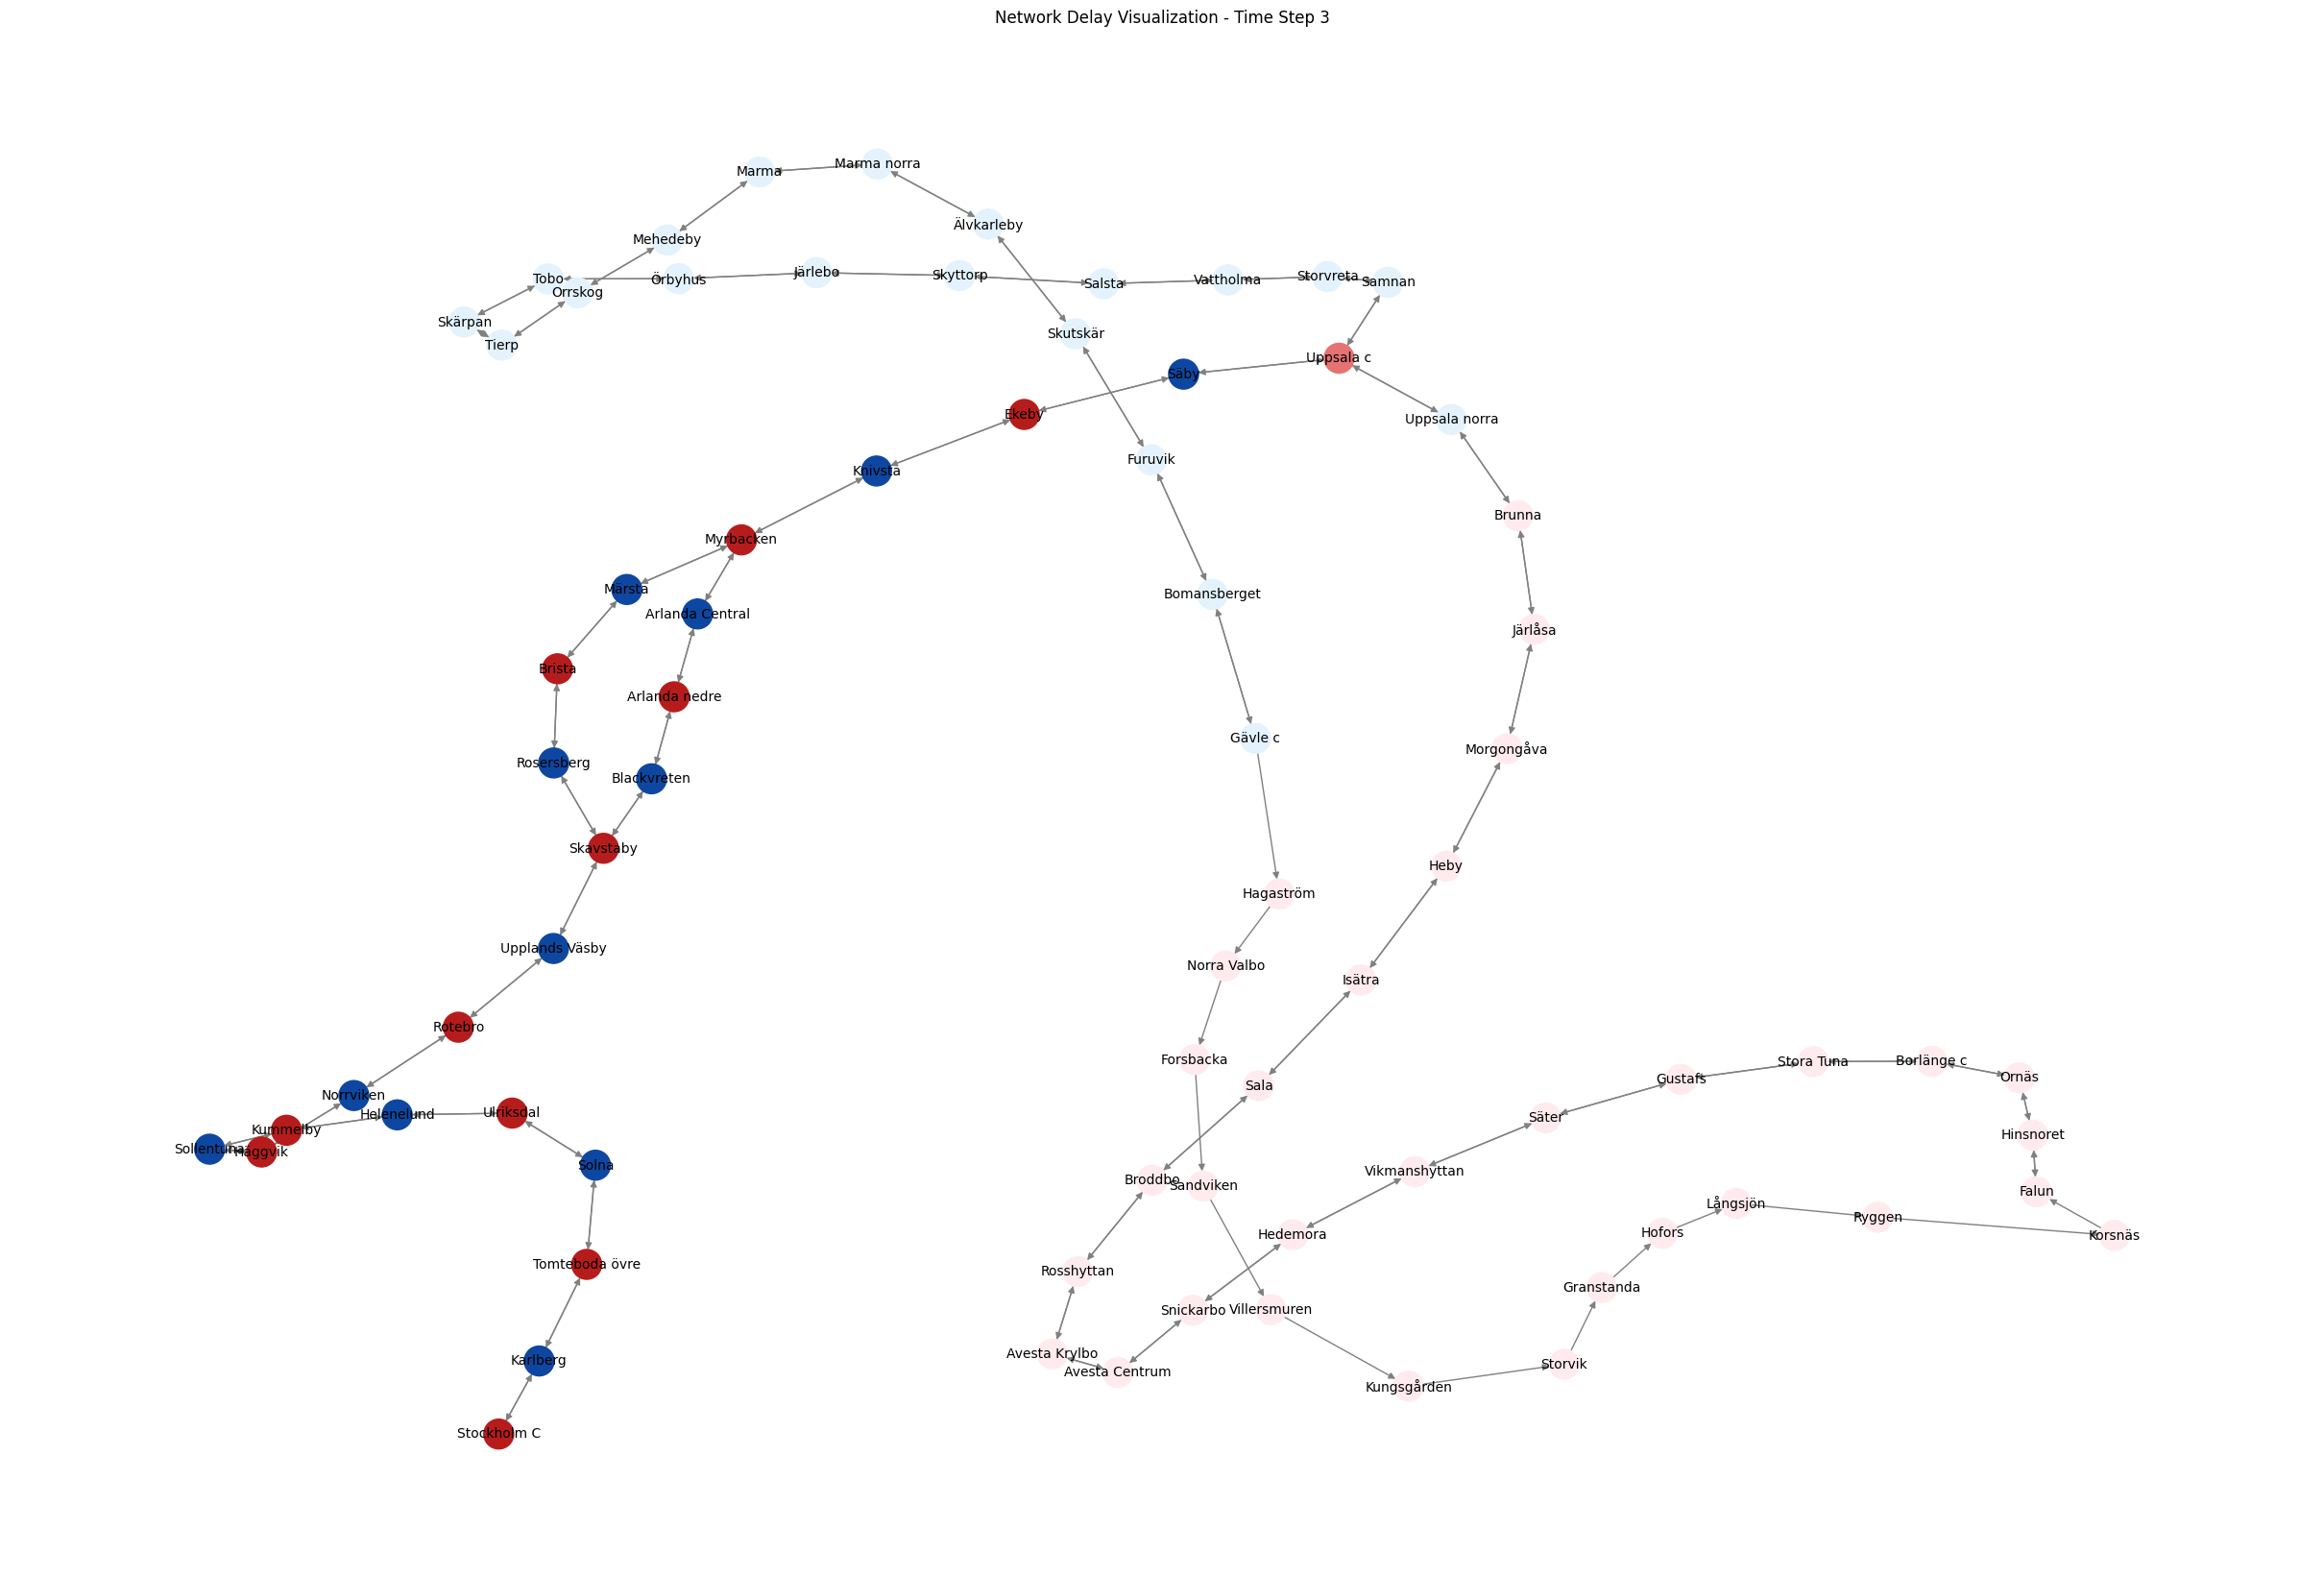

Visualizing delay for time step 3
Network time:  2019-03-27 07:53:00
Delay matrix at time:  2019-03-27 07:53:00
Rosersberg: -1228491428.729
Skavstaby: 22625927750.559
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: -7425848.902
Uppsala norra: -0.092
Solna: -2307035366579.437
Tomteboda övre: 317880184496.127
Samnan: -0.007
Karlberg: -59300949386.177
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: 1821.01
Ulriksdal: 13481999874033.197
Mehedeby: -0.0
Vattholma: -0.001
Arlanda Central: -6627960.051
Rotebro: 3717229008552.205
Salsta: -0.0
Helenelund: -93970418992516.0
Sollentuna: -124187829350179.19
Kummelby: 177668486428546.06
Myrbacken: 822216.103
Stockholm C: 4074103197.884
Örbyhus: -0.0
Norrviken: -14958563496862.172
Gävle c: -0.0
Blackvreten: -567064038.846
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: 97125958.513
Knivsta: -42251.369
Marma: -0.0
Häggvik: 40596353999013.25
Säby: -84.528
Storvreta: -0.0
Älvkarleby: -0.0
Arlanda nedre: 38192246.052
Skärpan: -0.0
Orrskog: -0.0
Upplands V

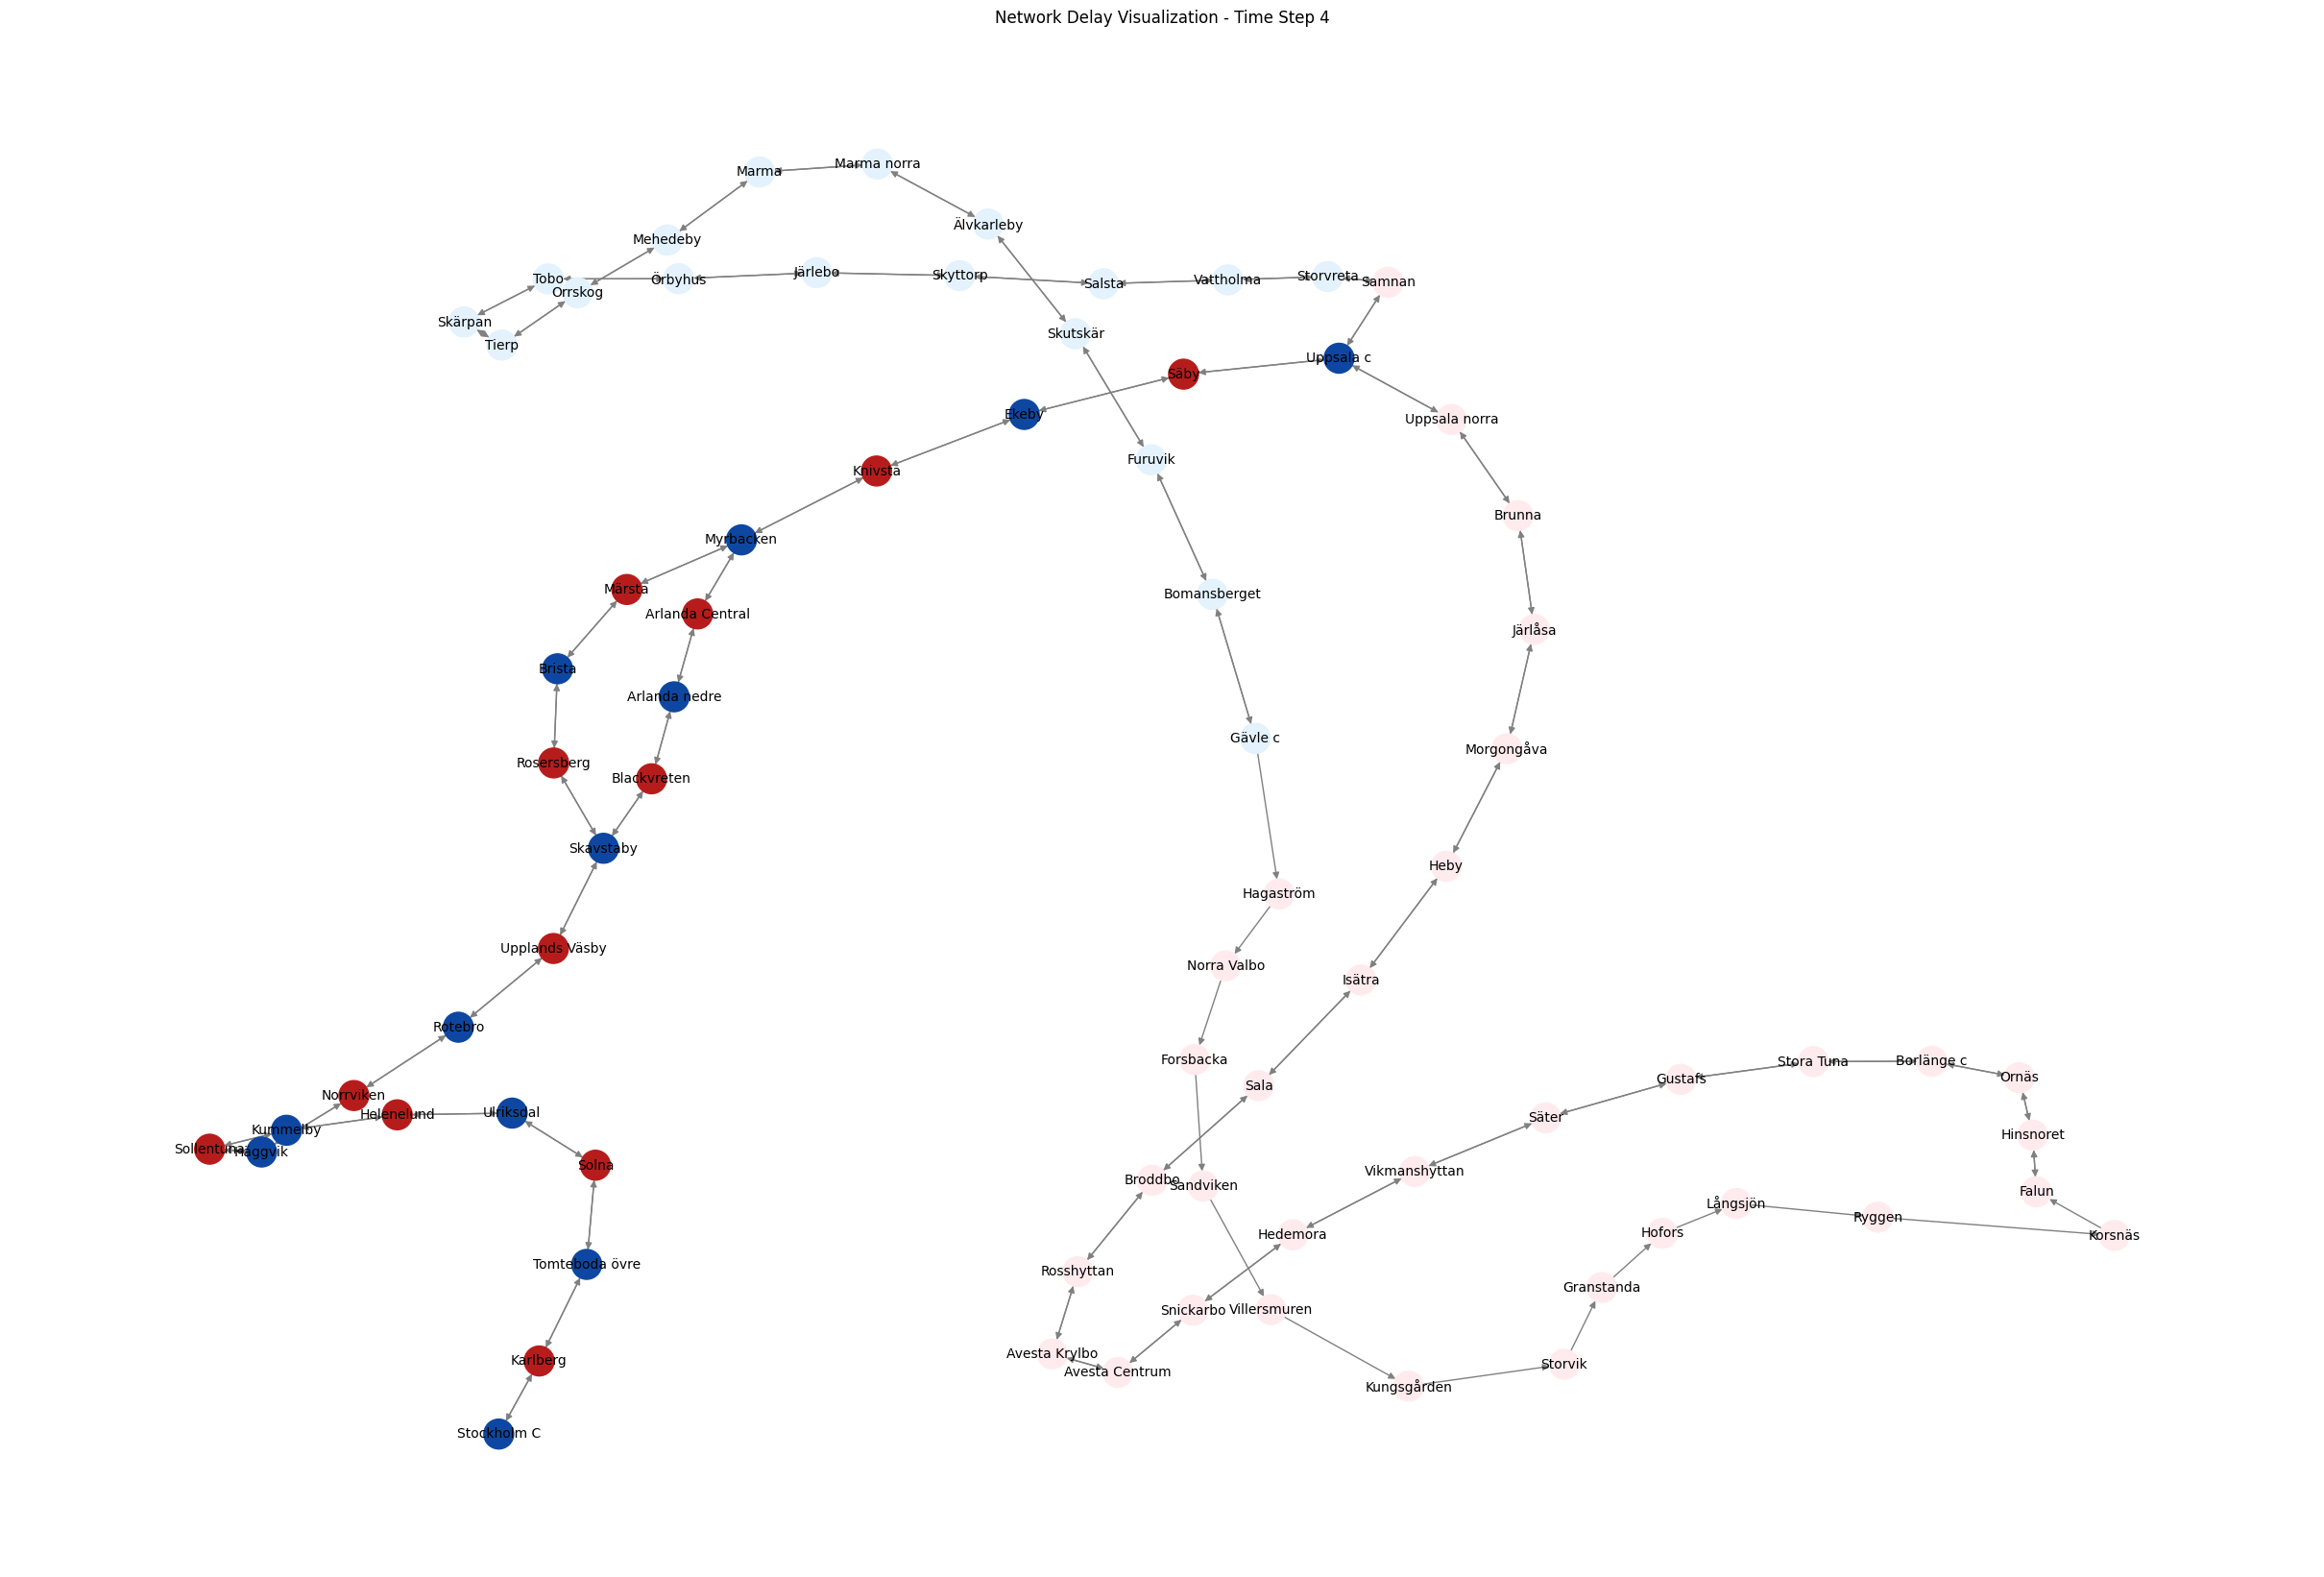

Visualizing delay for time step 4
Network time:  2019-03-27 07:54:00
Delay matrix at time:  2019-03-27 07:54:00
Rosersberg: 3971778363.75
Skavstaby: -73150832206.671
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: 24008165.695
Uppsala norra: 0.015
Solna: 7458768500253.93
Tomteboda övre: -1027723606409.978
Samnan: 0.021
Karlberg: 191723135136.018
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: -5887.501
Ulriksdal: -43588025322957.625
Mehedeby: -0.0
Vattholma: -0.001
Arlanda Central: 21428548.54
Rotebro: -12017999821836.576
Salsta: -0.0
Helenelund: 303811381166759.25
Sollentuna: 401505881986505.7
Kummelby: -574411701364740.8
Myrbacken: -2658268.632
Stockholm C: -13171793134.85
Örbyhus: -0.0
Norrviken: 48361834328045.58
Gävle c: -0.0
Blackvreten: 1833348306.619
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: -314013407.924
Knivsta: 136600.822
Marma: -0.0
Häggvik: -131250179680821.03
Säby: 273.243
Storvreta: -0.001
Älvkarleby: -0.0
Arlanda nedre: -123477569.956
Skärpan: -0.0
Orrskog: -0.0
U

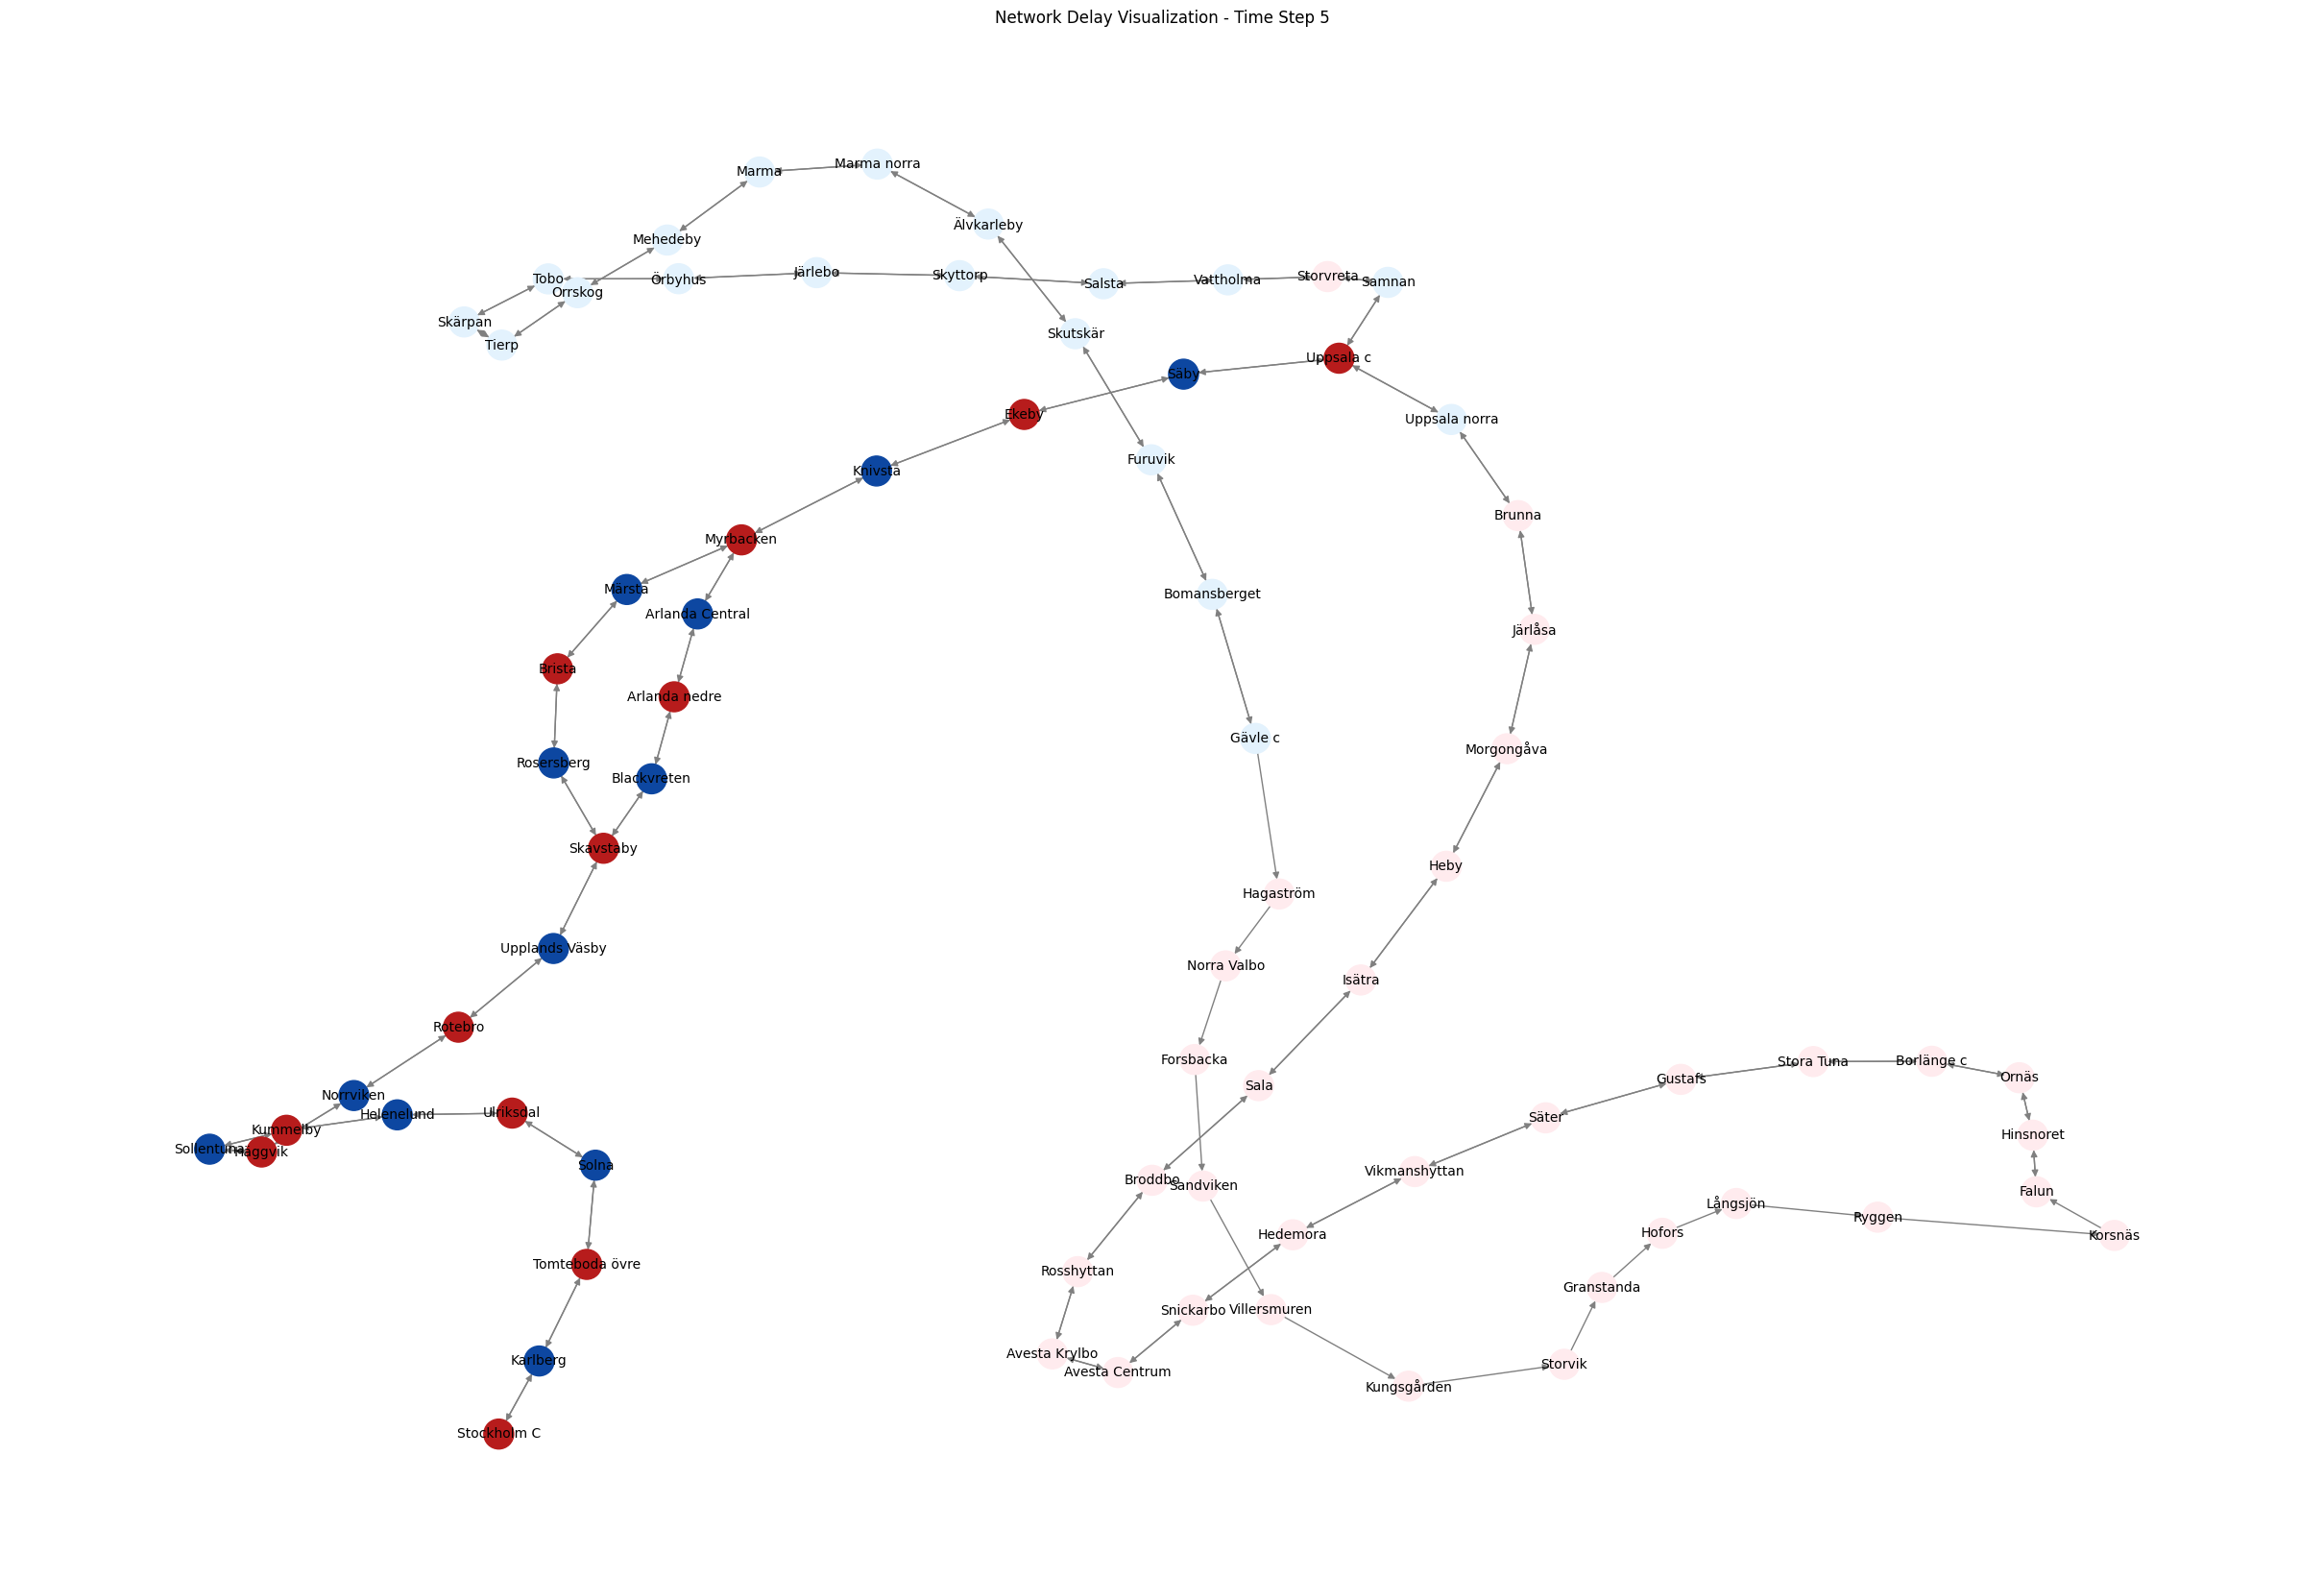

Visualizing delay for time step 5
Network time:  2019-03-27 07:55:00
Delay matrix at time:  2019-03-27 07:55:00
Rosersberg: -12840971467.483
Skavstaby: 236500545490.326
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: -77619681.24
Uppsala norra: -0.331
Solna: -24114596744173.5
Tomteboda övre: 3322685284129.578
Samnan: -0.071
Karlberg: -619851130970.562
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: 19034.529
Ulriksdal: 140922412794245.22
Mehedeby: -0.0
Vattholma: -0.001
Arlanda Central: -69279641.192
Rotebro: 38854834989306.47
Salsta: -0.0
Helenelund: -982238414127452.2
Sollentuna: -1298089950634275.0
Kummelby: 1857103695183175.2
Myrbacken: 8594324.259
Stockholm C: 42585110378.258
Örbyhus: -0.0
Norrviken: -156356392131271.38
Gävle c: -0.0
Blackvreten: -5927312941.577
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: 1015222109.378
Knivsta: -441637.851
Marma: -0.0
Häggvik: 424338837606325.25
Säby: -883.449
Storvreta: 0.002
Älvkarleby: -0.0
Arlanda nedre: 399209574.699
Skärpan: -0.0
Orrskog

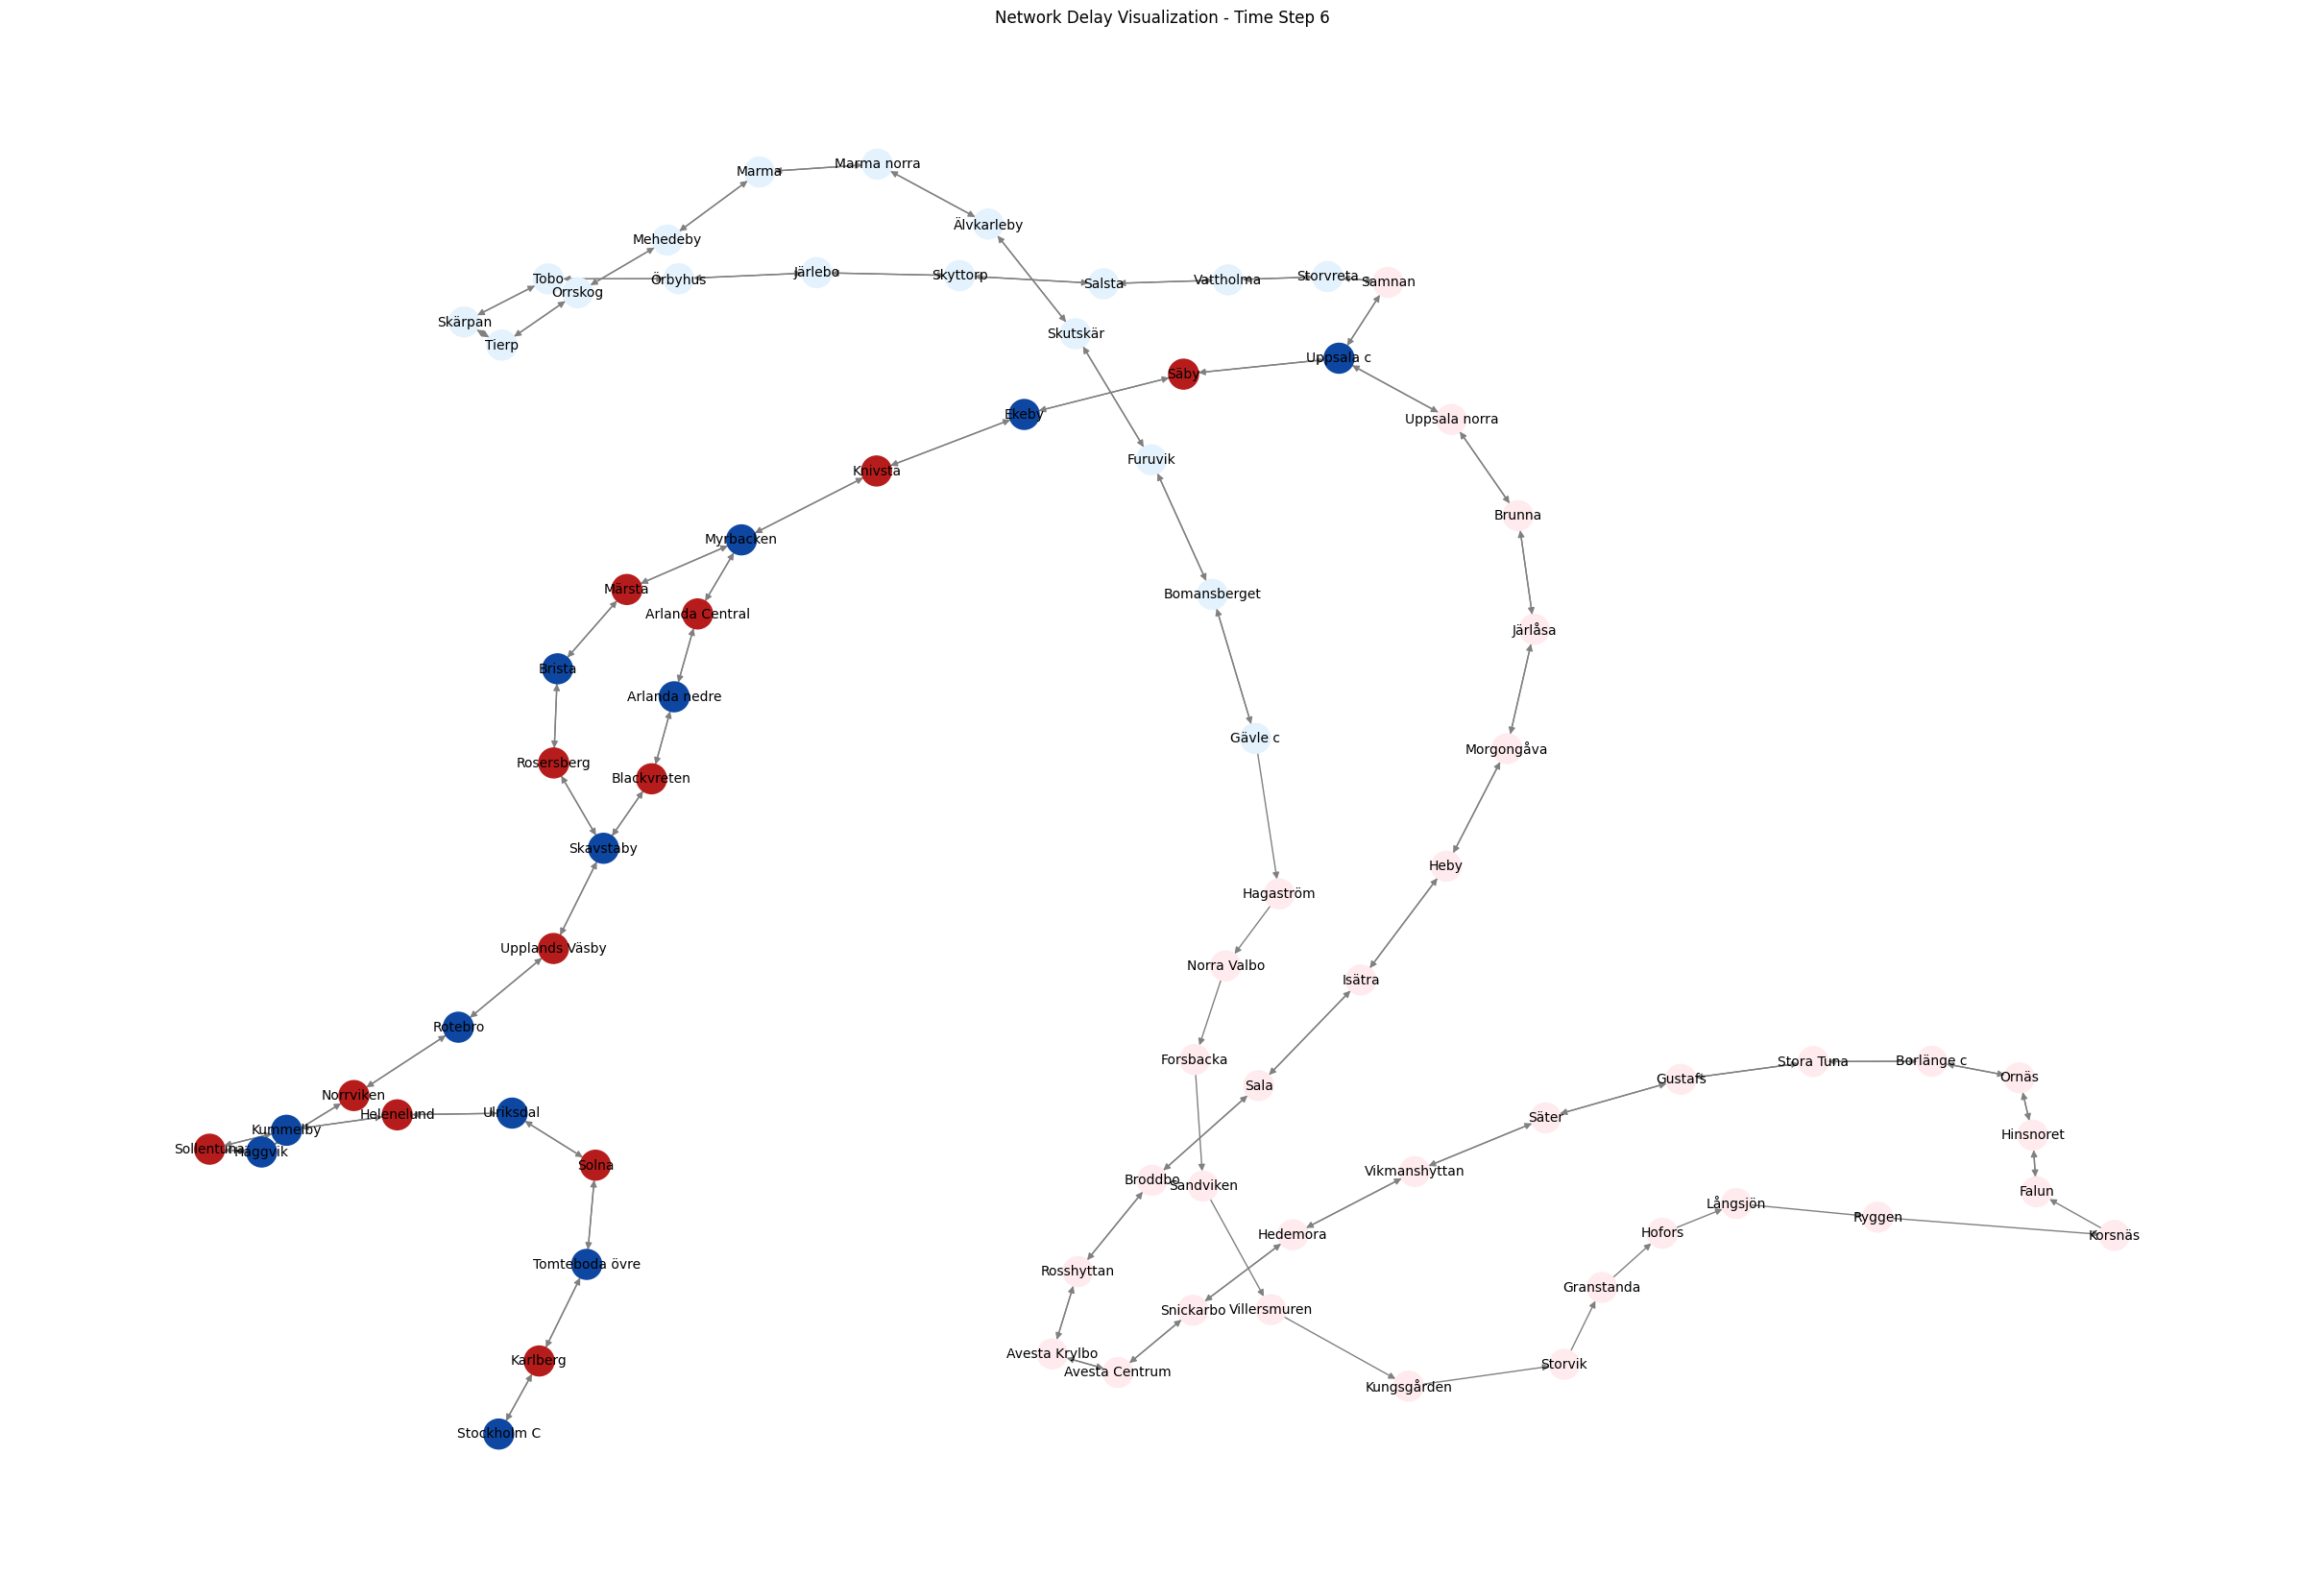

Visualizing delay for time step 6
Network time:  2019-03-27 07:56:00
Delay matrix at time:  2019-03-27 07:56:00
Rosersberg: 41515546237.725
Skavstaby: -764618888751.297
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: 250948572.63
Uppsala norra: 0.786
Solna: 77963778619727.06
Tomteboda övre: -10742418903616.816
Samnan: 0.227
Karlberg: 2004011796921.358
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: -61539.72
Ulriksdal: -455609683635015.75
Mehedeby: -0.0
Vattholma: -0.0
Arlanda Central: 223984778.033
Rotebro: -125619755748519.94
Salsta: -0.0
Helenelund: 3175629229163017.0
Sollentuna: 4196794108234143.0
Kummelby: -6004115387038521.0
Myrbacken: -27785909.156
Stockholm C: -137679935243.931
Örbyhus: -0.0
Norrviken: 505508562723557.6
Gävle c: -0.0
Blackvreten: 19163319155.556
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: -3282267273.443
Knivsta: 1427838.64
Marma: -0.0
Häggvik: -1371910115044058.2
Säby: 2856.2
Storvreta: -0.008
Älvkarleby: -0.0
Arlanda nedre: -1290665865.256
Skärpan: -0.0
Or

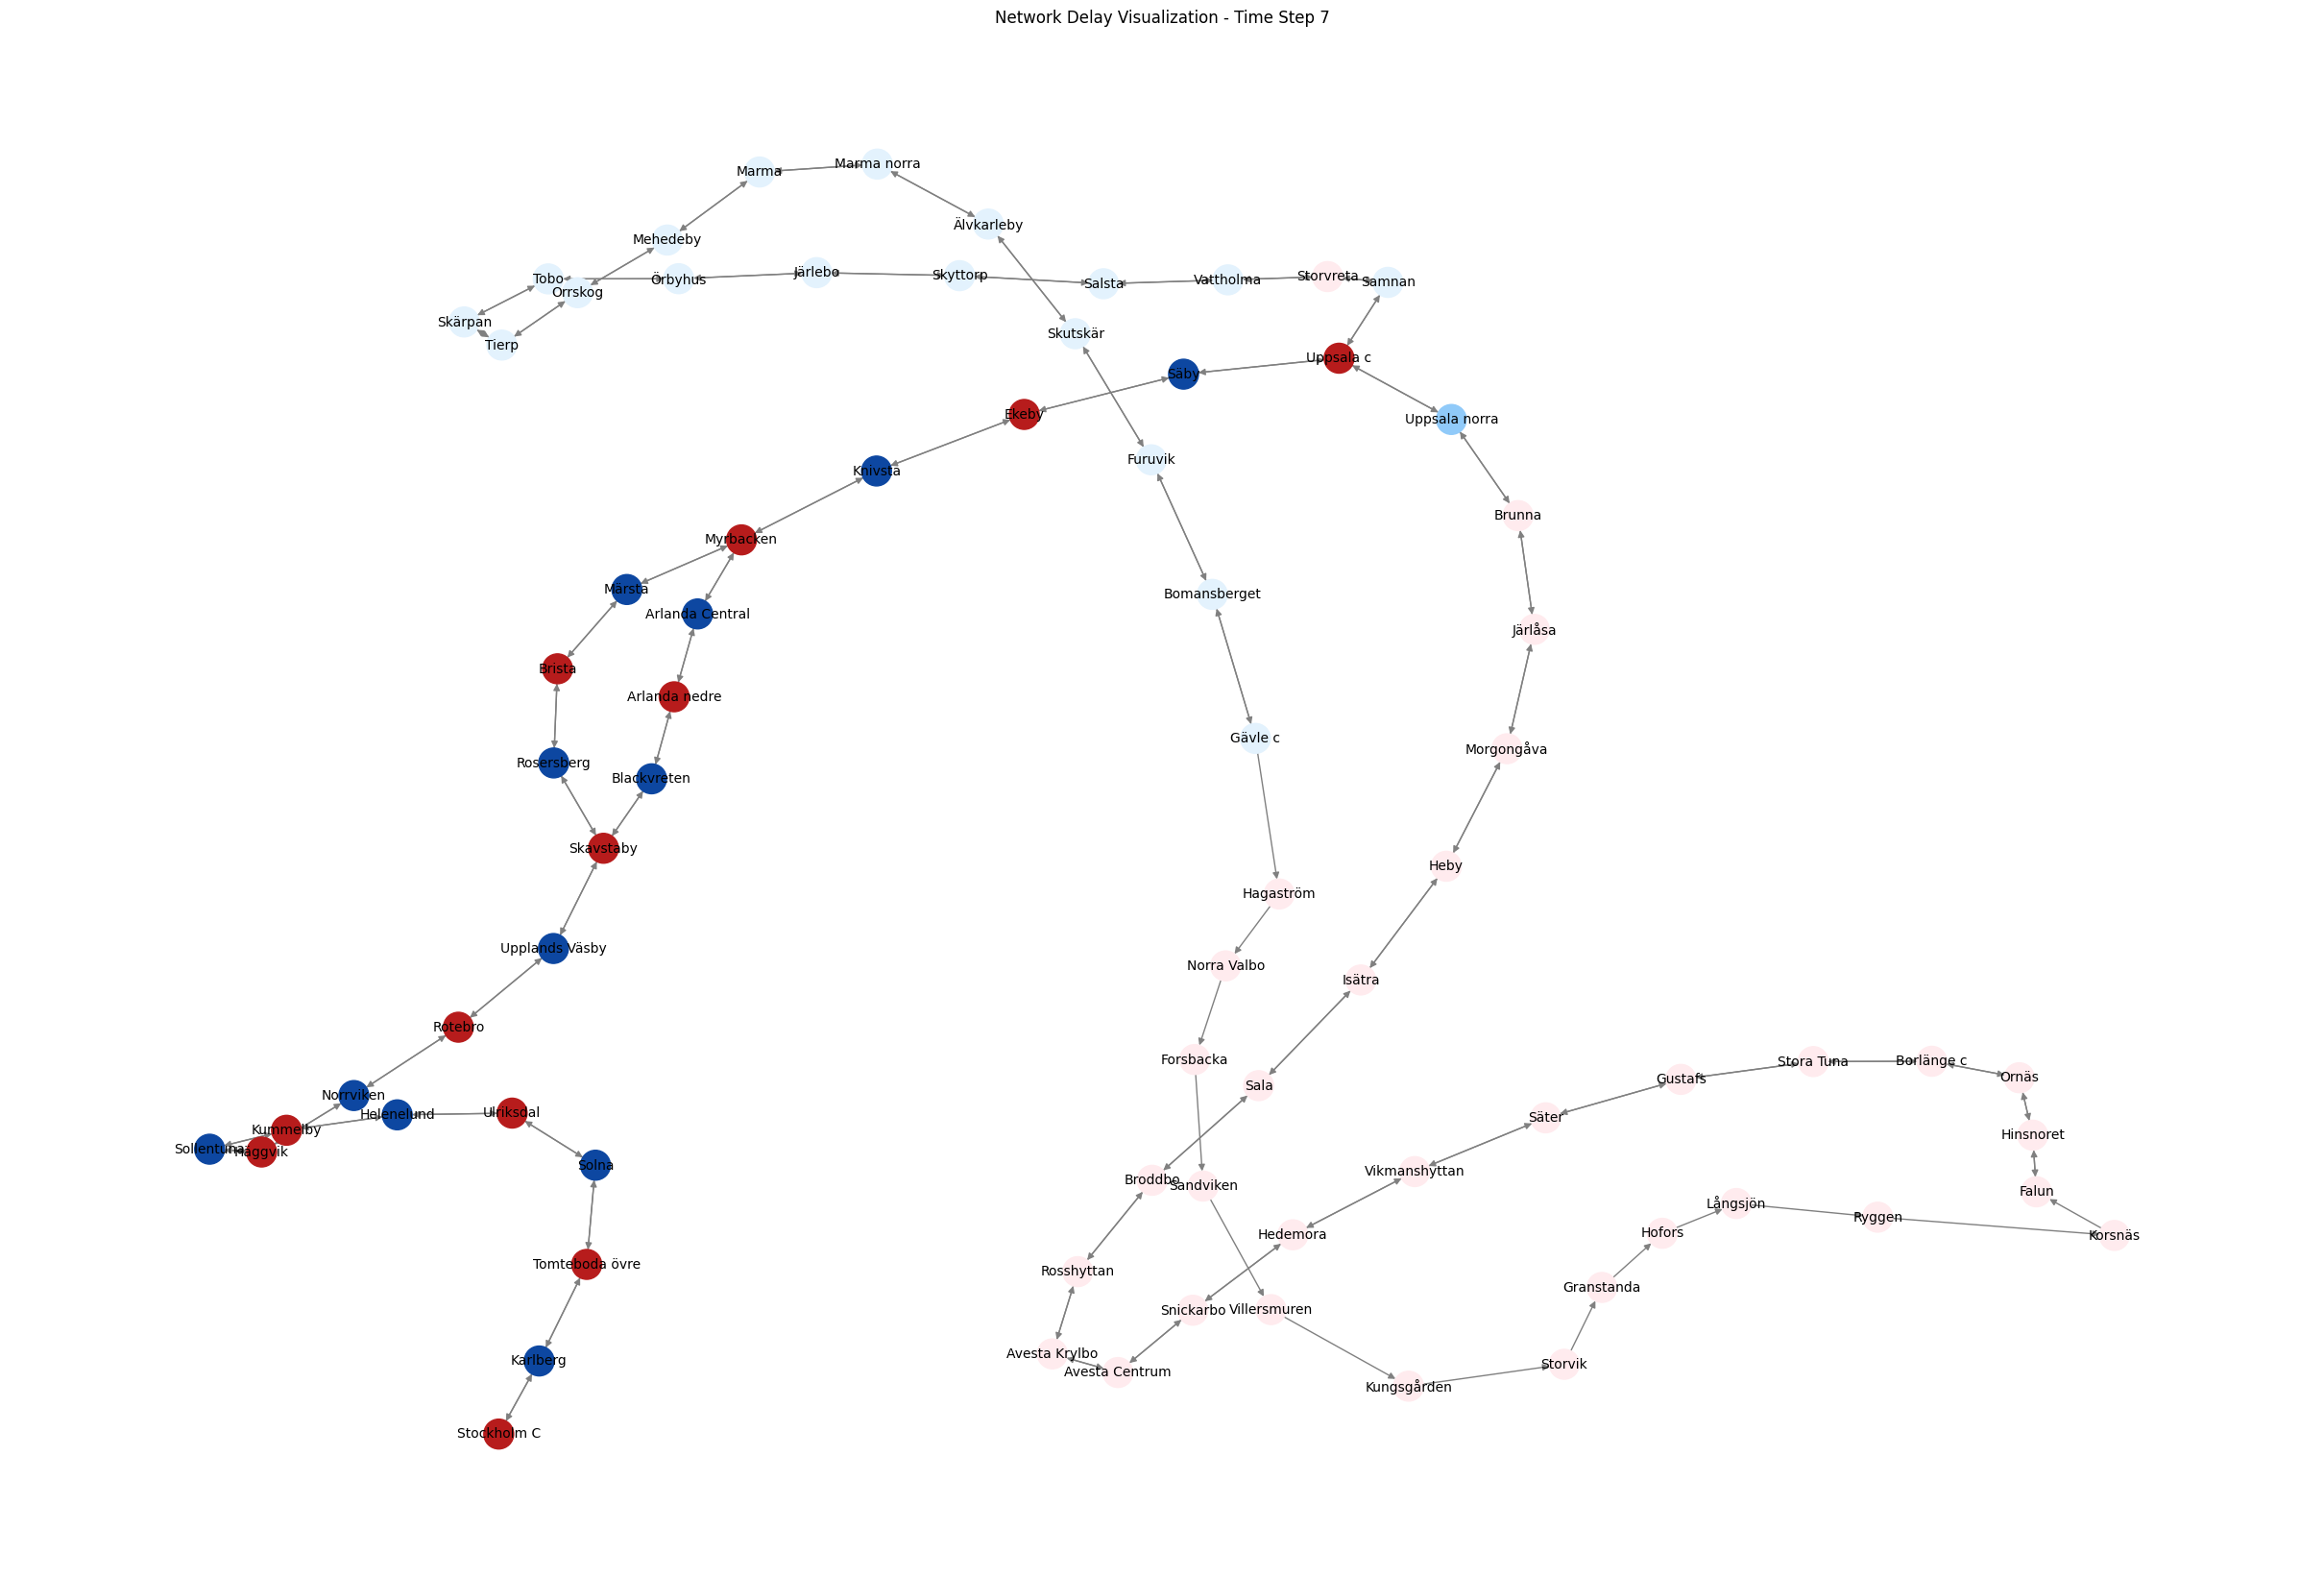

Visualizing delay for time step 7
Network time:  2019-03-27 07:57:00
Delay matrix at time:  2019-03-27 07:57:00
Rosersberg: -134221977226.721
Skavstaby: 2472053685609.656
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: -811330131.447
Uppsala norra: -2.826
Solna: -252061058334223.62
Tomteboda övre: 34730813794169.99
Samnan: -0.735
Karlberg: -6479077122682.963
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: 198961.127
Ulriksdal: 1473010429679394.8
Mehedeby: -0.0
Vattholma: -0.002
Arlanda Central: -724154744.022
Rotebro: 406135376449019.0
Salsta: -0.0
Helenelund: -1.0266978827193232e+16
Sollentuna: -1.3568459395537084e+16
Kummelby: 1.941162557284861e+16
Myrbacken: 89833327.408
Stockholm C: 445126580627.73
Örbyhus: -0.0
Norrviken: -1634336169520304.2
Gävle c: -0.0
Blackvreten: -61956033833.69
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: 10611745311.094
Knivsta: -4616278.64
Marma: -0.0
Häggvik: 4435458640559268.0
Säby: -9234.283
Storvreta: 0.025
Älvkarleby: -0.0
Arlanda nedre: 4172791641.

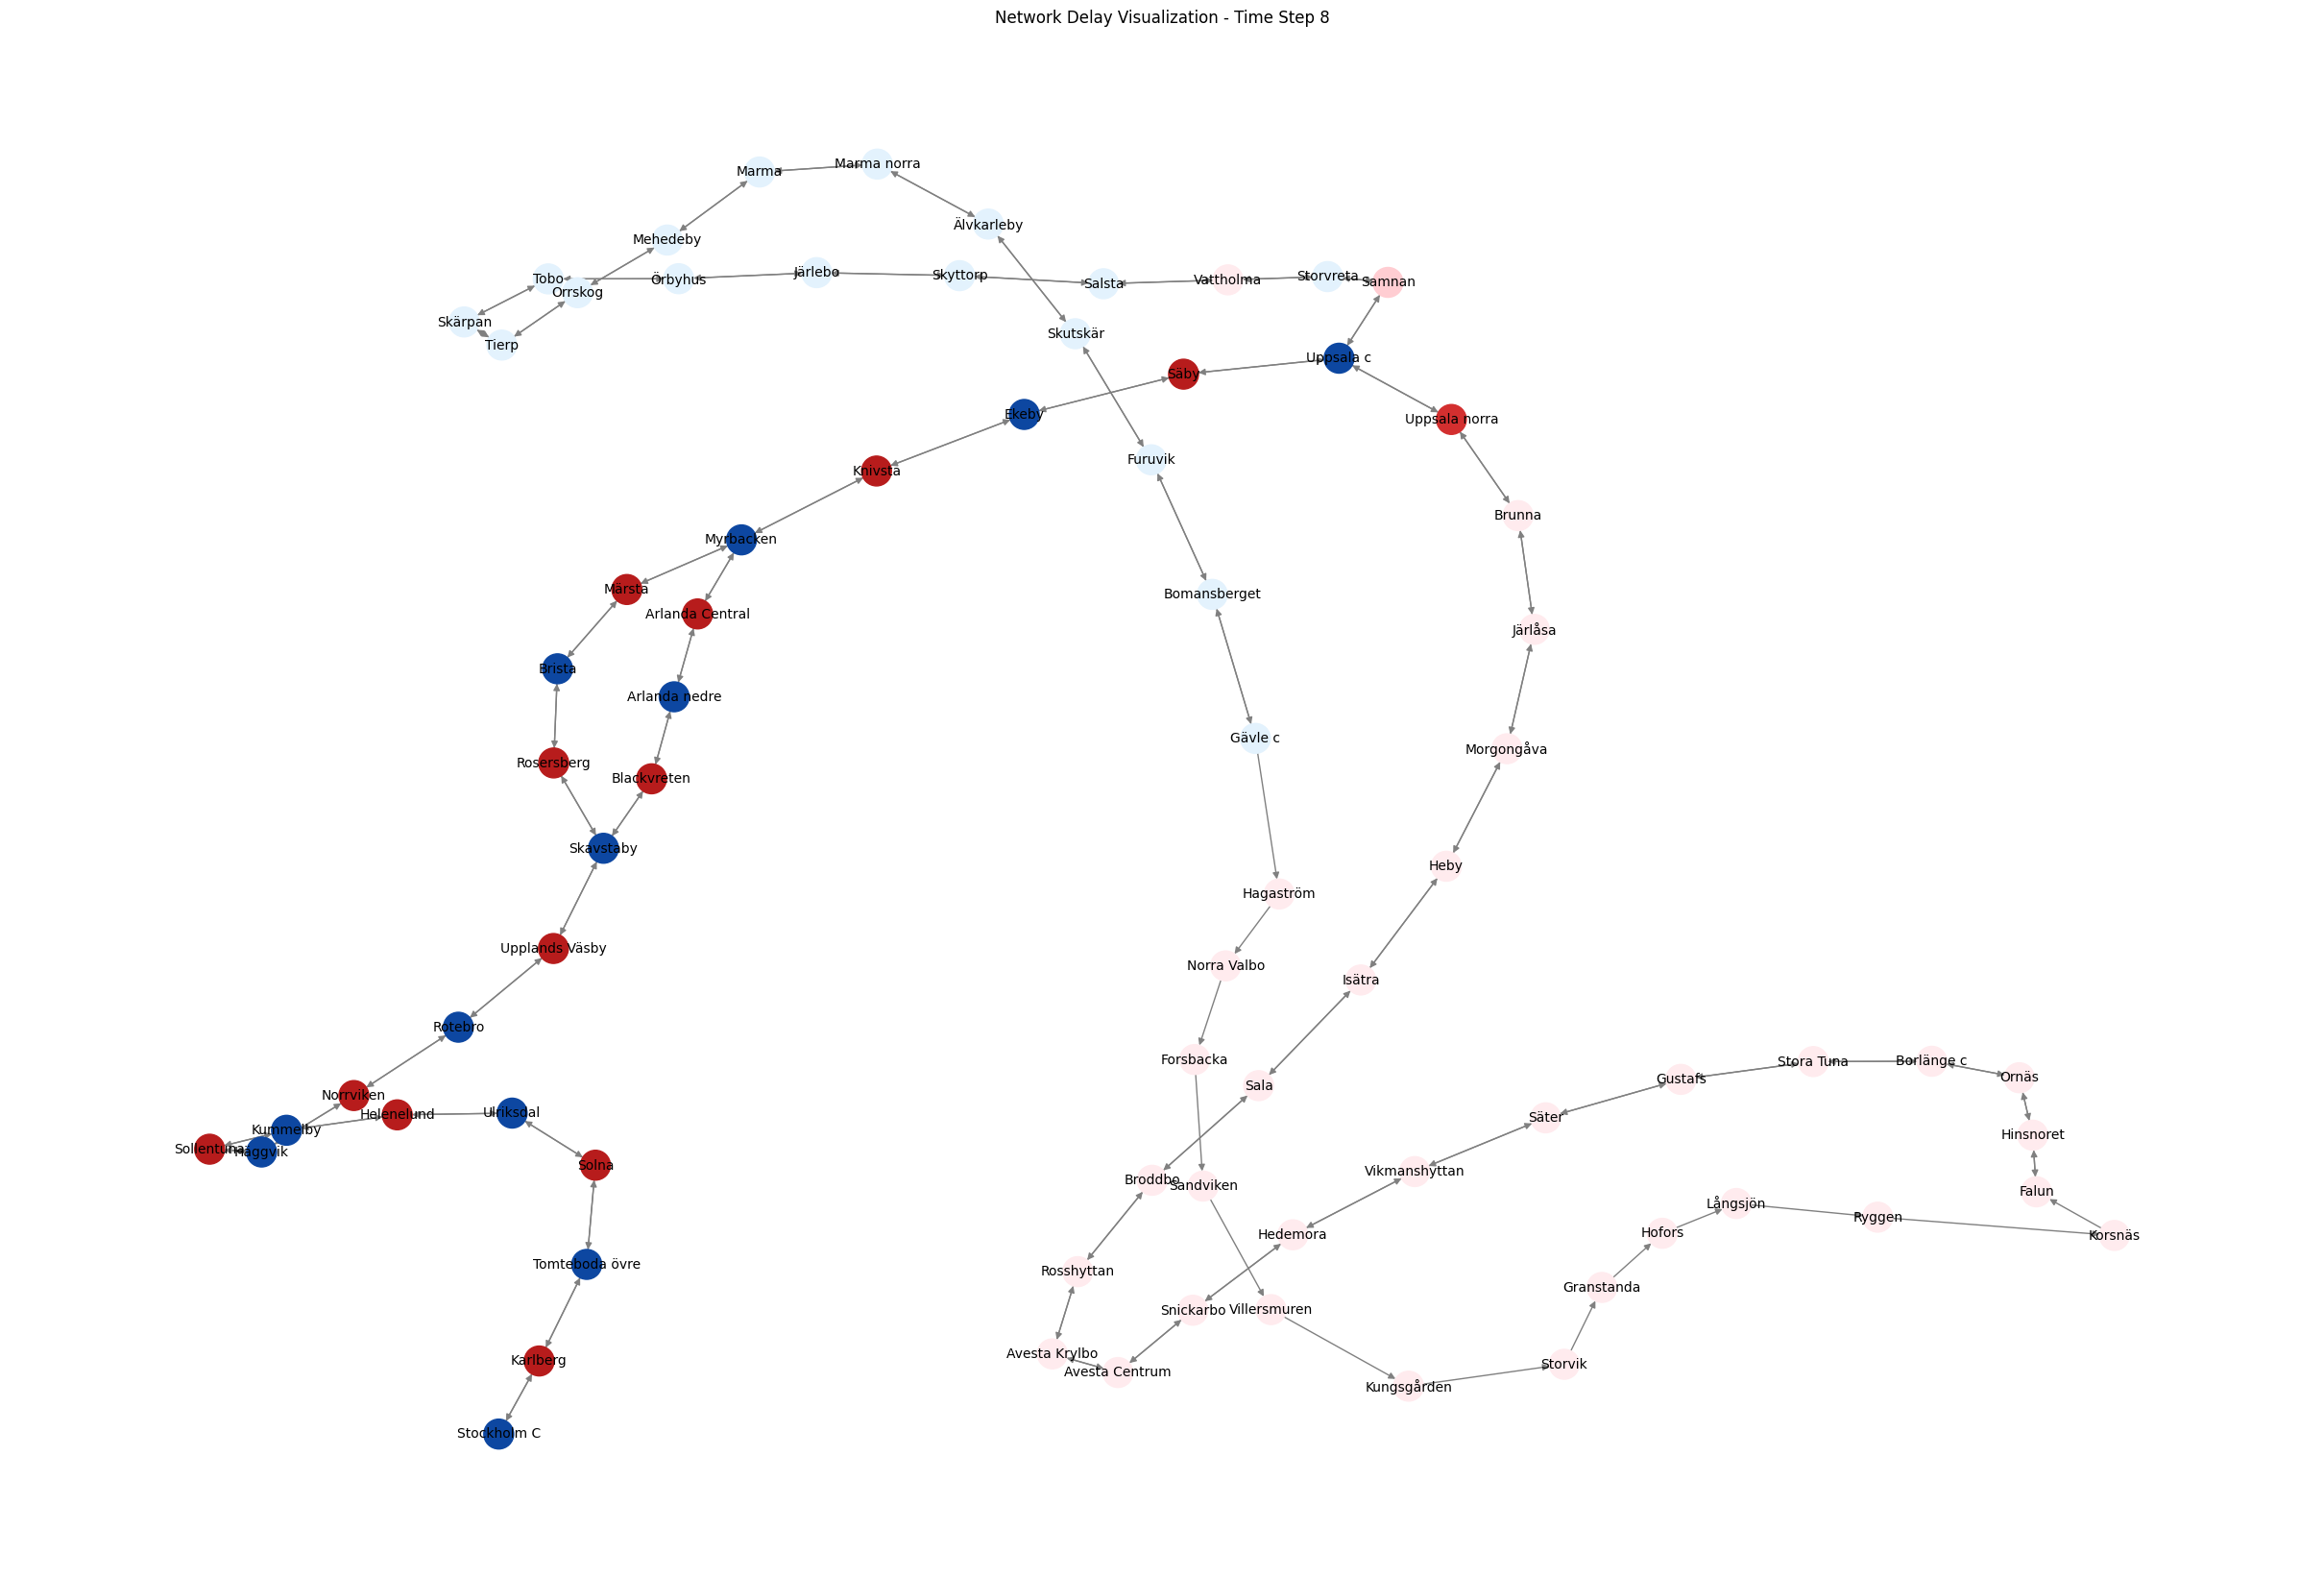

Visualizing delay for time step 8
Network time:  2019-03-27 07:58:00
Delay matrix at time:  2019-03-27 07:58:00
Rosersberg: 433946817661.19
Skavstaby: -7992281533954.764
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: 2623073625.985
Uppsala norra: 8.851
Solna: 814926857743887.8
Tomteboda övre: -112286575083479.3
Samnan: 2.374
Karlberg: 20947202219974.258
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: -643252.015
Ulriksdal: -4762321355047345.0
Mehedeby: -0.0
Vattholma: 0.005
Arlanda Central: 2341230944.783
Rotebro: -1313057353327697.5
Salsta: -0.0
Helenelund: 3.3193690645600296e+16
Sollentuna: 4.386755357078046e+16
Kummelby: -6.275882175645398e+16
Myrbacken: -290435943.067
Stockholm C: -1439117998041.534
Örbyhus: -0.0
Norrviken: 5283896084101903.0
Gävle c: -0.0
Blackvreten: 200307164838.406
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: -34308339082.359
Knivsta: 14924675.161
Marma: -0.0
Häggvik: -1.434007456941174e+16
Säby: 29854.894
Storvreta: -0.082
Älvkarleby: -0.0
Arlanda nedre: -1

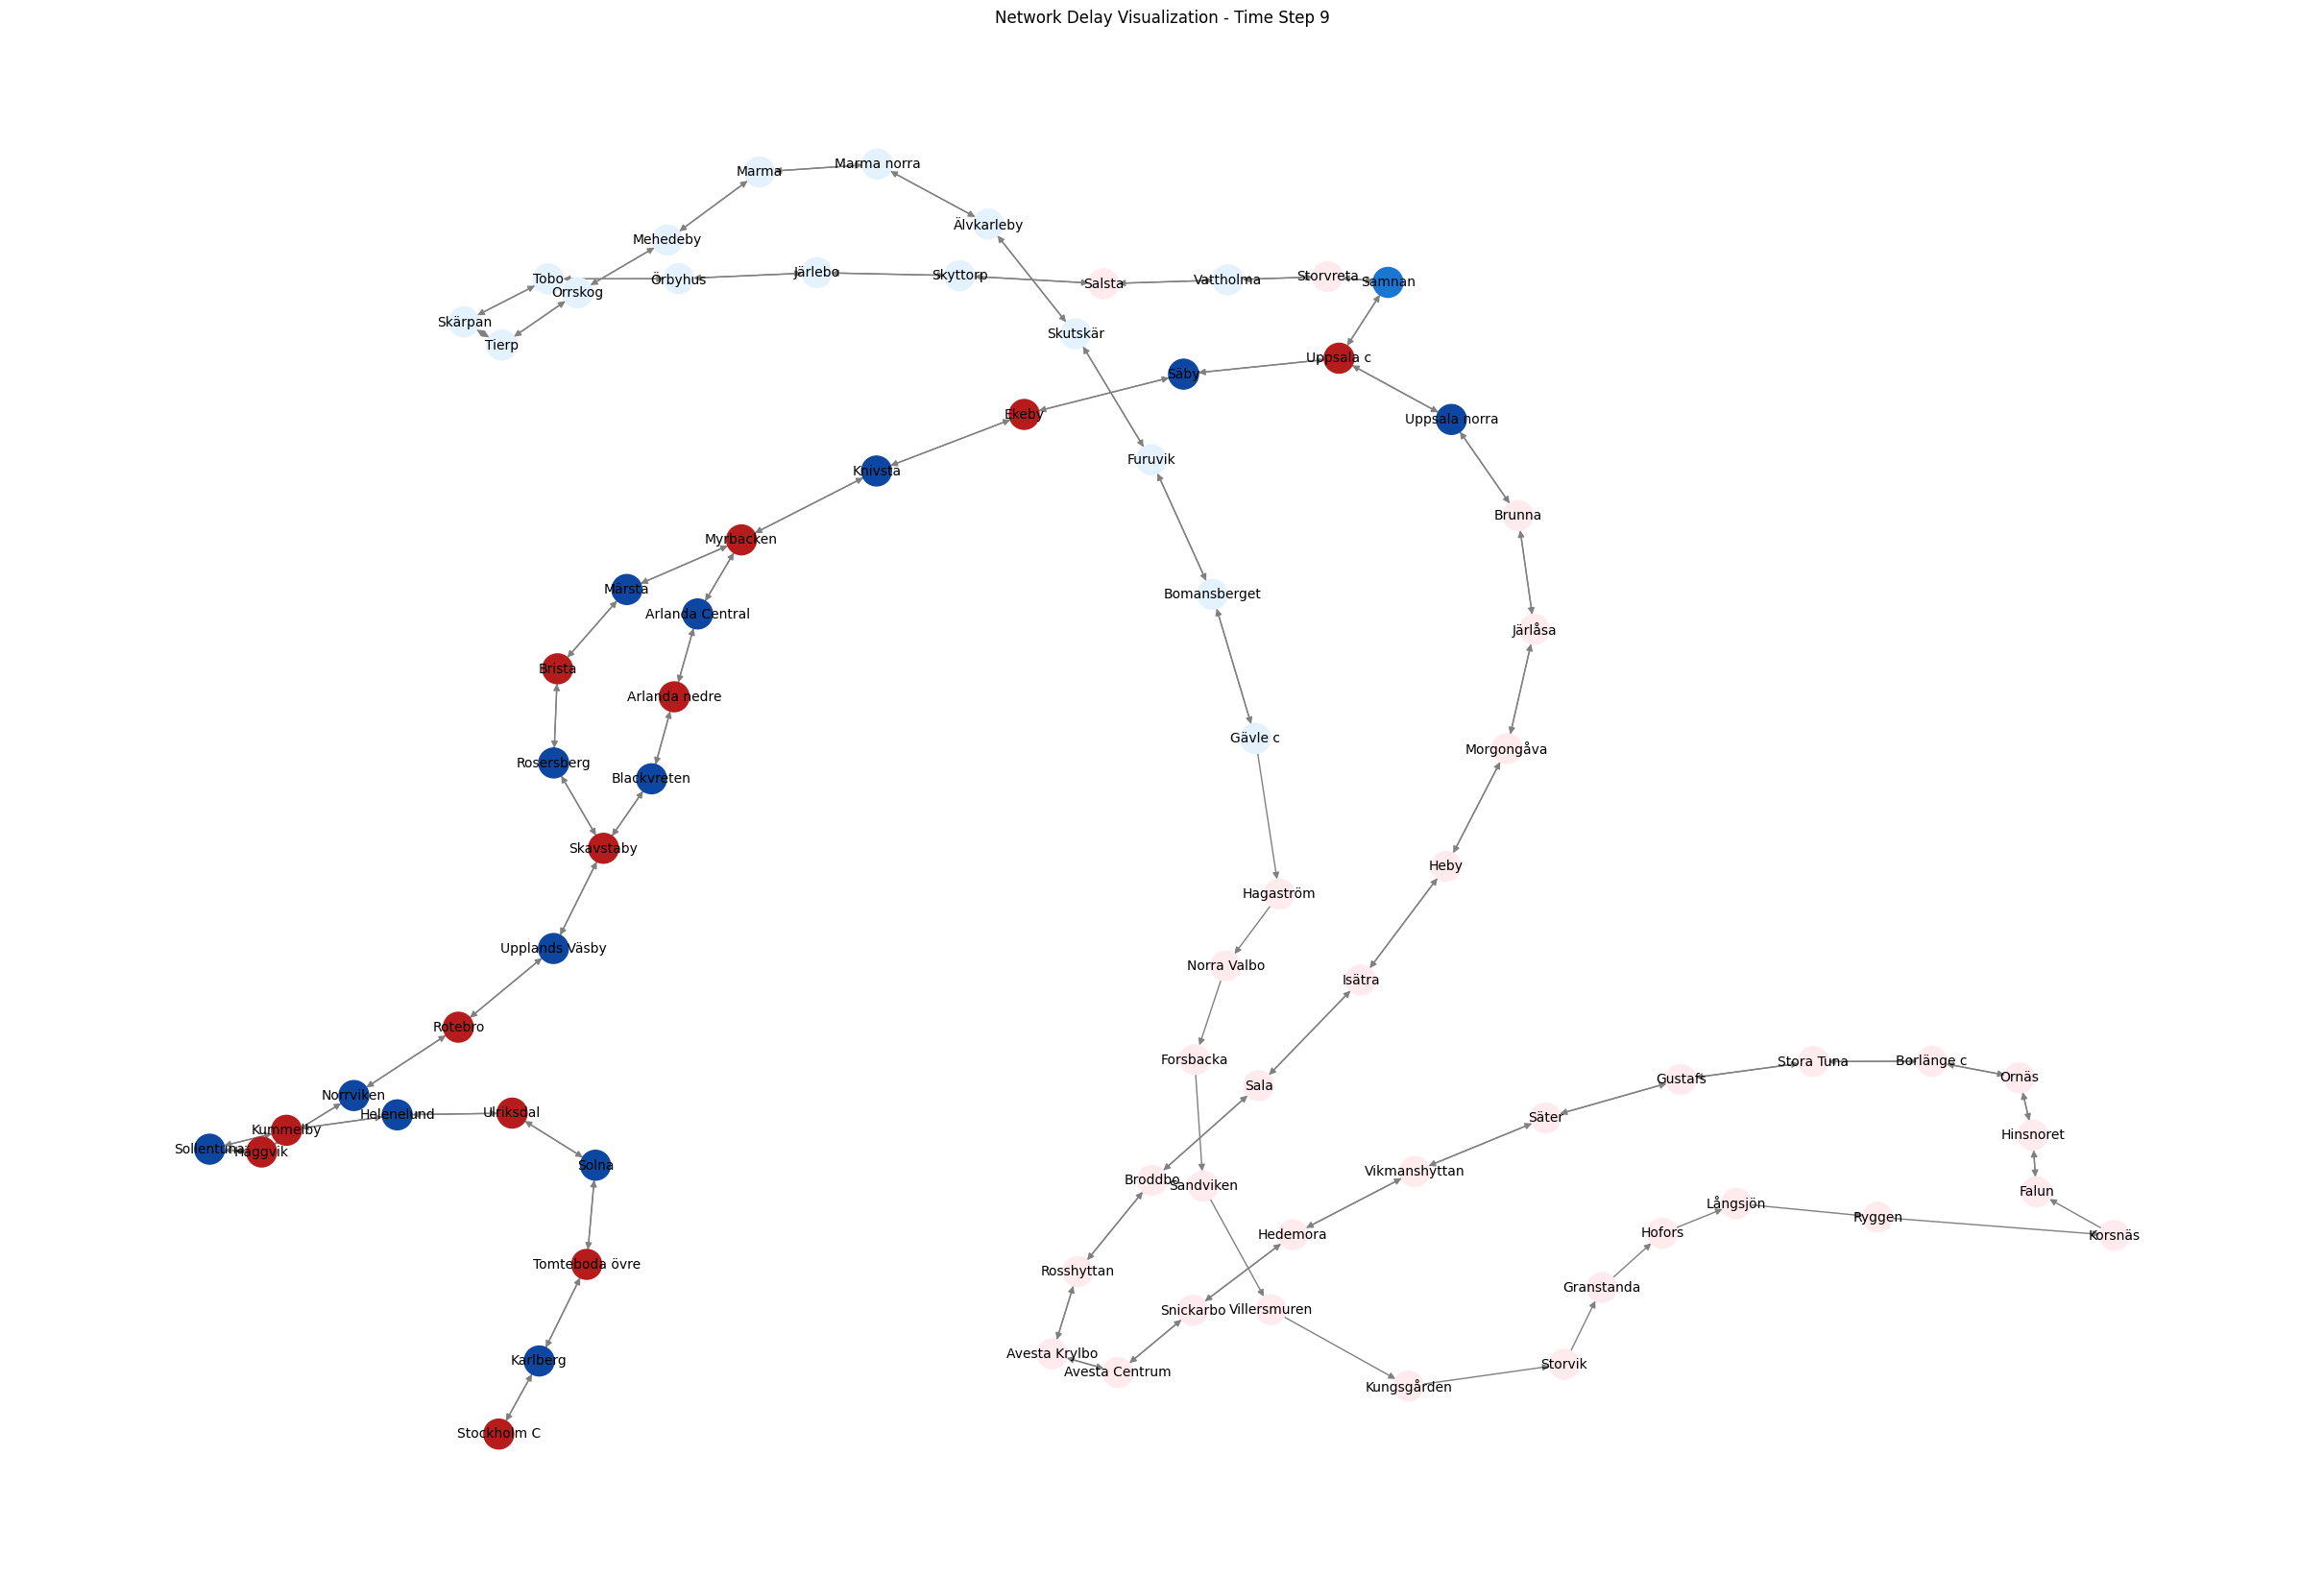

Visualizing delay for time step 9
Network time:  2019-03-27 07:59:00
Delay matrix at time:  2019-03-27 07:59:00
Rosersberg: -1402973227371.894
Skavstaby: 25839472861376.234
Bomansberget: -0.0
Marma norra: -0.0
Skutskär: -0.0
Märsta: -8480537061.933
Uppsala norra: -28.901
Solna: -2634702035531571.0
Tomteboda övre: 363028491605868.7
Samnan: -7.677
Karlberg: -67723423032932.99
Skyttorp: -0.0
Järlebo: -0.001
Ekeby: 2079668.033
Ulriksdal: 1.5396839174899432e+16
Mehedeby: -0.0
Vattholma: -0.018
Arlanda Central: -7569324627.633
Rotebro: 4245184520083765.0
Salsta: 0.001
Helenelund: -1.0731697388496627e+17
Sollentuna: -1.4182614254048472e+17
Kummelby: 2.0290262108530726e+17
Myrbacken: 938994908.176
Stockholm C: 4652745314268.064
Örbyhus: -0.0
Norrviken: -1.7083118117670116e+16
Gävle c: -0.0
Blackvreten: -647603757149.664
Furuvik: -0.0
Tierp: -0.0
Tobo: -0.0
Brista: 110920691766.118
Knivsta: -48252271.604
Marma: -0.0
Häggvik: 4.636222661998254e+16
Säby: -96522.502
Storvreta: 0.265
Älvkarleby: -0

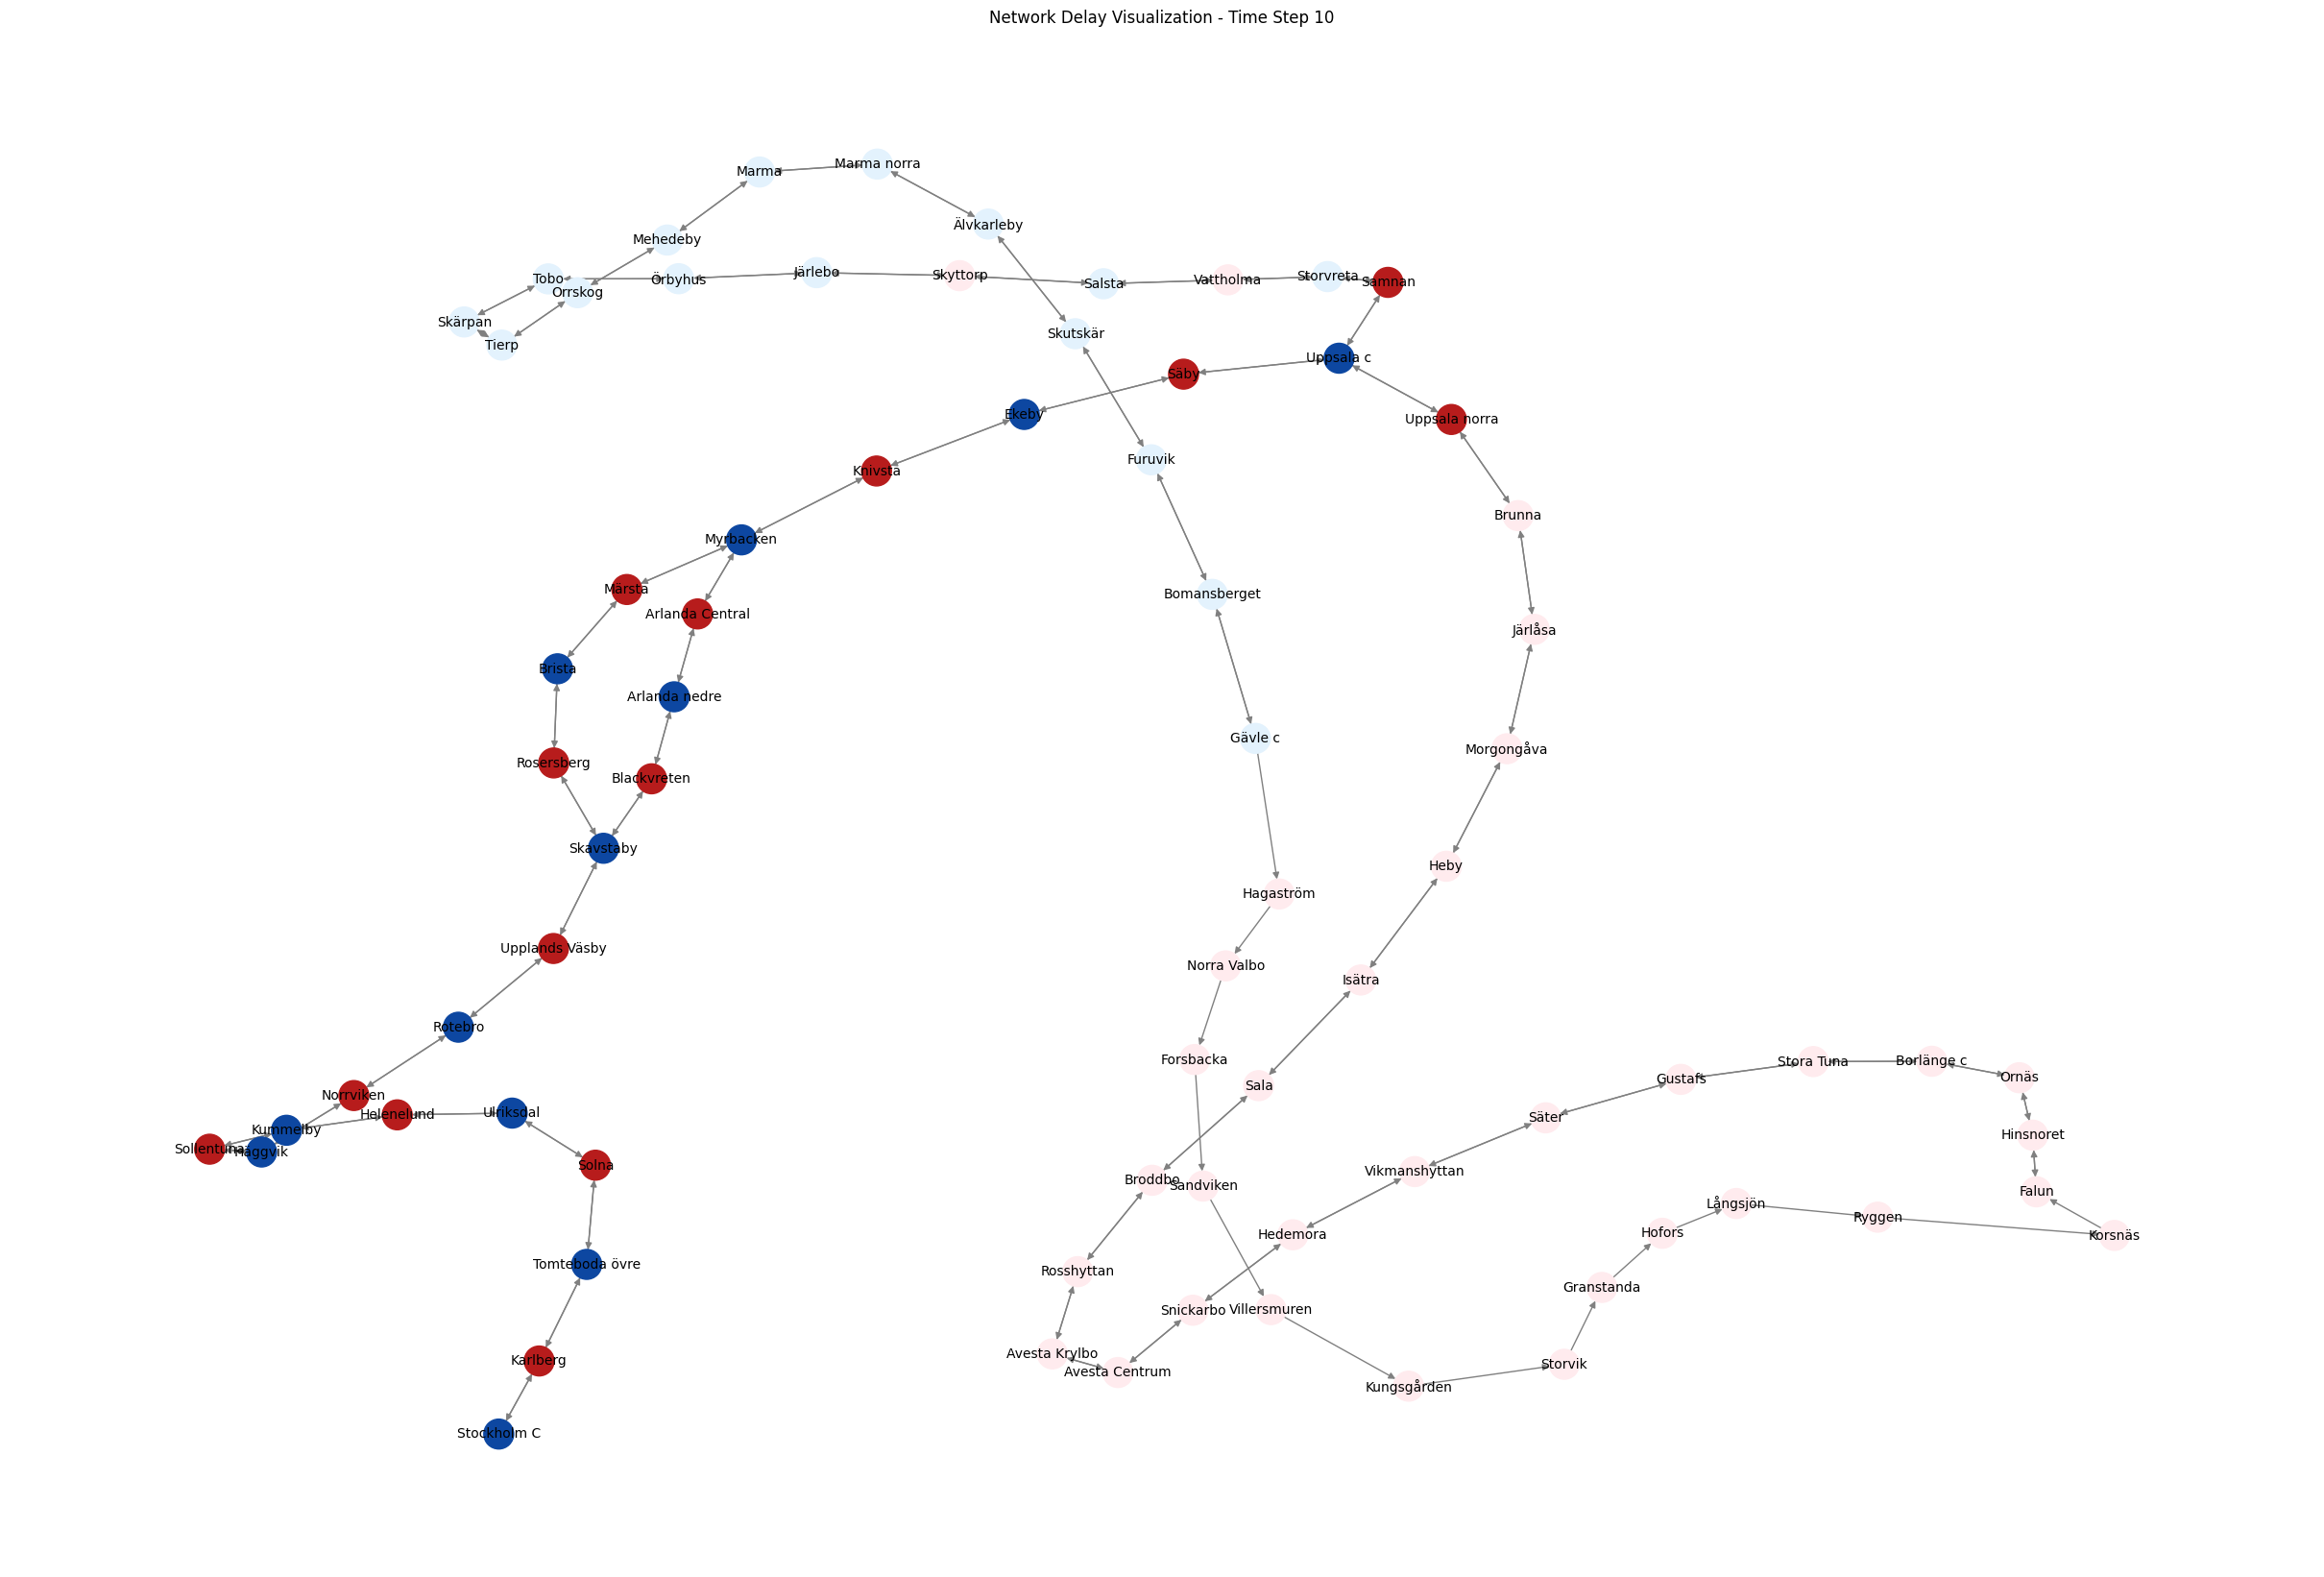

In [18]:
# Define color map for delays
color_map = {
    # Blue shades for negative values
    -15: "#0D47A1",  # Dark Blue (Very Large Negative)
    -10: "#1976D2",  # Deep Blue
    -5: "#42A5F5",   # Medium Blue
    -3: "#90CAF9",   # Light Blue
    -1: "#E3F2FD",   # Very Light Blue (Close to 0)

    # Red shades for positive values
    1: "#FFEBEE",    # Very Light Red (Close to 0)
    3: "#FFCDD2",    # Light Red
    5: "#E57373",    # Medium Red
    10: "#D32F2F",   # Deep Red
    15: "#B71C1C"    # Dark Red (Very Large Positive)
}

# Function to get color based on value
def get_color(value):
    if value < 0:
        for key in sorted(color_map.keys(), reverse=True):
            if value >= key:
                return color_map[key]
    else:
        for key in sorted(color_map.keys()):
            if value <= key:
                return color_map[key]
    return color_map[key]

# Number of time steps to visualize
time_steps = 10

    

# Visualization for time steps
for step in range(time_steps):
    print(f"Visualizing delay for time step {step}")
    print("Network time: ", network.current_time)
    network.print_delay_matrix(print_all=False)
    
    if step != 0:
        network.predict_time_step()

    # Get the updated delay matrix
    delay_matrix = network.D_matrix
    
    # Aggregate delays into a dictionary for visualization
    station_delays = {station: delay_matrix[idx][0] for station, idx in network.station_indicies.items()}
    
    # Create the graph
    G = nx.MultiDiGraph()
    for (start, end), edge in network.edges.items():
        G.add_edge(start, end)

    # Assign colors to nodes based on delays
    node_colors = [get_color(station_delays[station]) if station in station_delays else "#FFFFFF" for station in G.nodes]

    # Visualize the graph
    plt.figure(figsize=(24, 16))
    pos = nx.spring_layout(G, seed =42)
    scaled_pos = {node: (x * 4, y * 4) for node, (x, y) in pos.items()}
    #pos = nx.nx_agraph.graphviz_layout(G, prog="neato")  # Use consistent layout

    # Draw the graph with colored nodes
    nx.draw(
        G, pos, with_labels=True, node_color=node_colors, node_size=500,
        font_size=10, edge_color='gray', arrows=True
    )

    # Add edge labels if needed
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Add a title for the time step
    plt.title(f"Network Delay Visualization - Time Step {step + 1}")
    plt.show()
